### Prerequsite - Upgrade Scikit Learn
The current workspace has scikit-learn v0.19.1 installed. However, you can upgrade scikit-learn to 0.24.x. and use this [OneHotEncoder](https://scikit-learn.org/0.21/modules/generated/sklearn.preprocessing.OneHotEncoder.html) library. 


In [1]:
import sklearn
print('The scikit-learn version is {}.'.format(sklearn.__version__))

The scikit-learn version is 0.19.1.


In [2]:
import os
os.environ['PATH'] = f"{os.environ['PATH']}:/root/.local/bin"

In [2]:
# Now you can import and use OneHotEncoder
from sklearn.preprocessing import OneHotEncoder
# your code goes here

In [1]:
# Similarly, should you need any other package, they can install it as:
# !python -m pip install 'tensorflow-tensorboard<0.2.0,>=0.1.0'

# Project: Identify Customer Segments
## Rachel Wilson

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

This notebook will help you complete this task by providing a framework within which you will perform your analysis steps. In each step of the project, you will see some text describing the subtask that you will perform, followed by one or more code cells for you to complete your work. **Feel free to add additional code and markdown cells as you go along so that you can explore everything in precise chunks.** The code cells provided in the base template will outline only the major tasks, and will usually not be enough to cover all of the minor tasks that comprise it.

It should be noted that while there will be precise guidelines on how you should handle certain tasks in the project, there will also be places where an exact specification is not provided. **There will be times in the project where you will need to make and justify your own decisions on how to treat the data.** These are places where there may not be only one way to handle the data. In real-life tasks, there may be many valid ways to approach an analysis task. One of the most important things you can do is clearly document your approach so that other scientists can understand the decisions you've made.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, you will report your findings for the completed section, as well as document the decisions that you made in your approach to each subtask. **Your project will be evaluated not just on the code used to complete the tasks outlined, but also your communication about your observations and conclusions at each stage.**

In [1]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import PercentFormatter
from scipy import stats
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans


# magic word for producing visualizations in notebook
%matplotlib inline

'''
Import note: The classroom currently uses sklearn version 0.19.
If you need to use an imputer, it is available in sklearn.preprocessing.Imputer,
instead of sklearn.impute as in newer versions of sklearn.
'''
pd.options.display.max_rows = 200
pd.options.display.max_columns = 200

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

In [2]:
# Load in the general demographics data.
df_a = pd.read_csv('Udacity_AZDIAS_Subset.csv', sep=';')
# Load in the feature summary file.
feat = pd.read_csv('AZDIAS_Feature_Summary.csv', sep=';')

In [3]:
# Check the structure of the data after it's loaded (e.g. print the number of
# rows and columns, print the first few rows).

display(df_a.shape)

(891221, 85)

In [4]:
display(df_a.head())
display(feat.head())

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,GEBURTSJAHR,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,LP_FAMILIE_FEIN,LP_FAMILIE_GROB,LP_STATUS_FEIN,LP_STATUS_GROB,NATIONALITAET_KZ,PRAEGENDE_JUGENDJAHRE,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SHOPPER_TYP,SOHO_KZ,TITEL_KZ,VERS_TYP,ZABEOTYP,ALTER_HH,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,KK_KUNDENTYP,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,GEBAEUDETYP,KONSUMNAEHE,MIN_GEBAEUDEJAHR,OST_WEST_KZ,WOHNLAGE,CAMEO_DEUG_2015,CAMEO_DEU_2015,CAMEO_INTL_2015,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_BAUMAX,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,-1,2,1,2.0,3,4,3,5,5,3,4,0,10.0,0,-1,15.0,4.0,2.0,2.0,1.0,1.0,0,0,5.0,2,6,7,5,1,5,3,3,4,7,6,6,5,3,-1,NaN,NaN,-1,3,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-1,1,2,5.0,1,5,2,5,4,5,1,1996,10.0,0,3,21.0,6.0,5.0,3.0,2.0,1.0,1,14,1.0,5,4,4,3,1,2,2,3,6,4,7,4,7,6,3,1.0,0.0,2,5,0.0,2.0,0.0,6.0,NaN,3.0,9.0,11.0,0.0,8.0,1.0,1992.0,W,4.0,8,8A,51,0.0,0.0,0.0,2.0,5.0,1.0,6.0,3.0,8.0,3.0,2.0,1.0,3.0,3.0,963.0,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,-1,3,2,3.0,1,4,1,2,3,5,1,1979,10.0,1,3,3.0,1.0,1.0,1.0,3.0,2.0,1,15,3.0,4,1,3,3,4,4,6,3,4,7,7,7,3,3,2,0.0,0.0,1,5,17.0,1.0,0.0,4.0,NaN,3.0,9.0,10.0,0.0,1.0,5.0,1992.0,W,2.0,4,4C,24,1.0,3.0,1.0,0.0,0.0,3.0,2.0,4.0,4.0,4.0,2.0,3.0,2.0,2.0,712.0,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2,4,2,2.0,4,2,5,2,1,2,6,1957,1.0,0,2,0.0,0.0,0.0,0.0,9.0,4.0,1,8,2.0,5,1,2,1,4,4,7,4,3,4,4,5,4,4,1,0.0,0.0,1,3,13.0,0.0,0.0,1.0,NaN,NaN,9.0,1.0,0.0,1.0,4.0,1997.0,W,7.0,2,2A,12,4.0,1.0,0.0,0.0,1.0,4.0,4.0,2.0,6.0,4.0,0.0,4.0,1.0,0.0,596.0,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,-1,3,1,5.0,4,3,4,1,3,2,5,1963,5.0,0,3,32.0,10.0,10.0,5.0,3.0,2.0,1,8,5.0,6,4,4,2,7,4,4,6,2,3,2,2,4,2,2,0.0,0.0,2,4,20.0,4.0,0.0,5.0,1.0,2.0,9.0,3.0,0.0,1.0,4.0,1992.0,W,3.0,6,6B,43,1.0,4.0,1.0,0.0,0.0,3.0,2.0,5.0,1.0,5.0,3.0,3.0,5.0,5.0,435.0,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]


## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

**As one more reminder, you are encouraged to add additional cells to break up your analysis into manageable chunks.**

In [5]:
df_a.isnull().sum()

AGER_TYP                      0
ALTERSKATEGORIE_GROB          0
ANREDE_KZ                     0
CJT_GESAMTTYP              4854
FINANZ_MINIMALIST             0
FINANZ_SPARER                 0
FINANZ_VORSORGER              0
FINANZ_ANLEGER                0
FINANZ_UNAUFFAELLIGER         0
FINANZ_HAUSBAUER              0
FINANZTYP                     0
GEBURTSJAHR                   0
GFK_URLAUBERTYP            4854
GREEN_AVANTGARDE              0
HEALTH_TYP                    0
LP_LEBENSPHASE_FEIN        4854
LP_LEBENSPHASE_GROB        4854
LP_FAMILIE_FEIN            4854
LP_FAMILIE_GROB            4854
LP_STATUS_FEIN             4854
LP_STATUS_GROB             4854
NATIONALITAET_KZ              0
PRAEGENDE_JUGENDJAHRE         0
RETOURTYP_BK_S             4854
SEMIO_SOZ                     0
SEMIO_FAM                     0
SEMIO_REL                     0
SEMIO_MAT                     0
SEMIO_VERT                    0
SEMIO_LUST                    0
SEMIO_ERL                     0
SEMIO_KU

In [6]:
type(feat.missing_or_unknown[0])

str

In [7]:
feat.missing_or_unknown = feat.missing_or_unknown.str.strip('[').str.strip(']').str.split(',')

In [8]:
type(feat.missing_or_unknown[0])

list

In [9]:
# Identify missing or unknown data values and convert them to NaNs.

def replace_with_null(df, mapper, mapper_col_name, mapper_col_definition, non_num_indicators=[]):
    '''
    Replace the missing values in the selected dataframe with null or NAN values.
    
    Parameters:
    df (dataframe): dataframe to edit based on the mapper list.
    mapper (dataframe): The dataframe containing the null values and attributes.
    mapper_col_name (str): The column name containing the null values.
    mapper_col_definition (str): The null values column name.
    non_numerical_indicator: Used to assist with iterating through the list.
    
    Returns:
    df: dataframe object with correct missing values.
    '''
    for index, row in mapper.iterrows():
        if len(row[mapper_col_definition]) > 0 and row[mapper_col_definition] != ['']:
            try:
                replace_mask = []
                for nan_indicator in row[mapper_col_definition]:
                    
                    if nan_indicator in non_num_indicators:
                        replace_mask.append(nan_indicator)
                    else:
                        replace_mask.append(int(nan_indicator))
                        
                df[row[mapper_col_name]] = df[row[mapper_col_name]].replace(replace_mask, np.nan)
                
            except Exception as excpt:
                print('Exception: {} -> {} --> {}'.format(row[mapper_col_name], str(excpt), nan_indicator))
                continue
                
    return df

In [10]:
# New dataframe with edited values.
azdias_df = replace_with_null(df_a, feat, 'attribute', 'missing_or_unknown', non_num_indicators=['X', 'XX'])

In [11]:
azdias_df.isnull().sum()

AGER_TYP                 685843
ALTERSKATEGORIE_GROB       2881
ANREDE_KZ                     0
CJT_GESAMTTYP              4854
FINANZ_MINIMALIST             0
FINANZ_SPARER                 0
FINANZ_VORSORGER              0
FINANZ_ANLEGER                0
FINANZ_UNAUFFAELLIGER         0
FINANZ_HAUSBAUER              0
FINANZTYP                     0
GEBURTSJAHR              392318
GFK_URLAUBERTYP            4854
GREEN_AVANTGARDE              0
HEALTH_TYP               111196
LP_LEBENSPHASE_FEIN       97632
LP_LEBENSPHASE_GROB       94572
LP_FAMILIE_FEIN           77792
LP_FAMILIE_GROB           77792
LP_STATUS_FEIN             4854
LP_STATUS_GROB             4854
NATIONALITAET_KZ         108315
PRAEGENDE_JUGENDJAHRE    108164
RETOURTYP_BK_S             4854
SEMIO_SOZ                     0
SEMIO_FAM                     0
SEMIO_REL                     0
SEMIO_MAT                     0
SEMIO_VERT                    0
SEMIO_LUST                    0
SEMIO_ERL                     0
SEMIO_KU

#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

In [12]:
# Perform an assessment of how much missing data there is in each column of the
# dataset.

azdias_df.head()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,GEBURTSJAHR,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,LP_FAMILIE_FEIN,LP_FAMILIE_GROB,LP_STATUS_FEIN,LP_STATUS_GROB,NATIONALITAET_KZ,PRAEGENDE_JUGENDJAHRE,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SHOPPER_TYP,SOHO_KZ,TITEL_KZ,VERS_TYP,ZABEOTYP,ALTER_HH,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,KK_KUNDENTYP,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,GEBAEUDETYP,KONSUMNAEHE,MIN_GEBAEUDEJAHR,OST_WEST_KZ,WOHNLAGE,CAMEO_DEUG_2015,CAMEO_DEU_2015,CAMEO_INTL_2015,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_BAUMAX,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,NaN,2.0,1,2.0,3,4,3,5,5,3,4,NaN,10.0,0,NaN,15.0,4.0,2.0,2.0,1.0,1.0,NaN,NaN,5.0,2,6,7,5,1,5,3,3,4,7,6,6,5,3,NaN,NaN,NaN,NaN,3,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,1.0,2,5.0,1,5,2,5,4,5,1,1996.0,10.0,0,3.0,21.0,6.0,5.0,3.0,2.0,1.0,1.0,14.0,1.0,5,4,4,3,1,2,2,3,6,4,7,4,7,6,3.0,1.0,NaN,2.0,5,NaN,2.0,0.0,6.0,NaN,3.0,9.0,11.0,0.0,8.0,1.0,1992.0,W,4.0,8,8A,51,0.0,0.0,0.0,2.0,5.0,1.0,6.0,3.0,8.0,3.0,2.0,1.0,3.0,3.0,963.0,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,NaN,3.0,2,3.0,1,4,1,2,3,5,1,1979.0,10.0,1,3.0,3.0,1.0,1.0,1.0,3.0,2.0,1.0,15.0,3.0,4,1,3,3,4,4,6,3,4,7,7,7,3,3,2.0,0.0,NaN,1.0,5,17.0,1.0,0.0,4.0,NaN,3.0,9.0,10.0,0.0,1.0,5.0,1992.0,W,2.0,4,4C,24,1.0,3.0,1.0,0.0,NaN,3.0,2.0,4.0,4.0,4.0,2.0,3.0,2.0,2.0,712.0,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2.0,4.0,2,2.0,4,2,5,2,1,2,6,1957.0,1.0,0,2.0,NaN,NaN,NaN,NaN,9.0,4.0,1.0,8.0,2.0,5,1,2,1,4,4,7,4,3,4,4,5,4,4,1.0,0.0,NaN,1.0,3,13.0,0.0,0.0,1.0,NaN,NaN,9.0,1.0,0.0,1.0,4.0,1997.0,W,7.0,2,2A,12,4.0,1.0,0.0,0.0,1.0,4.0,4.0,2.0,6.0,4.0,NaN,4.0,1.0,NaN,596.0,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,NaN,3.0,1,5.0,4,3,4,1,3,2,5,1963.0,5.0,0,3.0,32.0,10.0,10.0,5.0,3.0,2.0,1.0,8.0,5.0,6,4,4,2,7,4,4,6,2,3,2,2,4,2,2.0,0.0,NaN,2.0,4,20.0,4.0,0.0,5.0,1.0,2.0,9.0,3.0,0.0,1.0,4.0,1992.0,W,3.0,6,6B,43,1.0,4.0,1.0,0.0,NaN,3.0,2.0,5.0,1.0,5.0,3.0,3.0,5.0,5.0,435.0,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


In [13]:
def create_hist(percent, y, x):
    '''
    Creates a histogram based on the percentage.
    
    Parameters:
    percent (vector): The percentage values to plot.
    y (str): The "# of" title.
    x (str): The "Amount of" title.
    
    Returns:
    None
    
    '''
    plt.hist(percent, bins=50)
    plt.ylabel(f"# of {y}",fontsize=12)
    plt.xlabel(f"Amount of {x}")
    plt.show()

In [14]:
missing_cols = azdias_df.isnull().sum()
percent_missing = missing_cols/len(azdias_df)*100

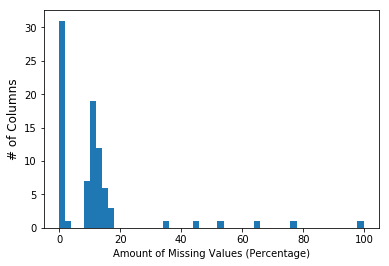

In [15]:
# Investigate patterns in the amount of missing data in each column.

create_hist(percent_missing, 'Columns', 'Missing Values (Percentage)')

In [16]:
# Remove the outlier columns from the dataset. (You'll perform other data
# engineering tasks such as re-encoding and imputation later.)

columns = percent_missing[percent_missing > 20]
columns_names = columns.keys().tolist()

In [17]:
azdias_df = azdias_df.drop(columns_names, axis=1)

In [18]:
azdias_df.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,LP_FAMILIE_FEIN,LP_FAMILIE_GROB,LP_STATUS_FEIN,LP_STATUS_GROB,NATIONALITAET_KZ,PRAEGENDE_JUGENDJAHRE,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SHOPPER_TYP,SOHO_KZ,VERS_TYP,ZABEOTYP,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,GEBAEUDETYP,KONSUMNAEHE,MIN_GEBAEUDEJAHR,OST_WEST_KZ,WOHNLAGE,CAMEO_DEUG_2015,CAMEO_DEU_2015,CAMEO_INTL_2015,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,2.0,1,2.0,3,4,3,5,5,3,4,10.0,0,NaN,15.0,4.0,2.0,2.0,1.0,1.0,NaN,NaN,5.0,2,6,7,5,1,5,3,3,4,7,6,6,5,3,NaN,NaN,NaN,3,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1.0,2,5.0,1,5,2,5,4,5,1,10.0,0,3.0,21.0,6.0,5.0,3.0,2.0,1.0,1.0,14.0,1.0,5,4,4,3,1,2,2,3,6,4,7,4,7,6,3.0,1.0,2.0,5,2.0,0.0,6.0,3.0,9.0,11.0,0.0,8.0,1.0,1992.0,W,4.0,8,8A,51,0.0,0.0,0.0,2.0,1.0,6.0,3.0,8.0,3.0,2.0,1.0,3.0,3.0,963.0,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,3.0,2,3.0,1,4,1,2,3,5,1,10.0,1,3.0,3.0,1.0,1.0,1.0,3.0,2.0,1.0,15.0,3.0,4,1,3,3,4,4,6,3,4,7,7,7,3,3,2.0,0.0,1.0,5,1.0,0.0,4.0,3.0,9.0,10.0,0.0,1.0,5.0,1992.0,W,2.0,4,4C,24,1.0,3.0,1.0,0.0,3.0,2.0,4.0,4.0,4.0,2.0,3.0,2.0,2.0,712.0,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,4.0,2,2.0,4,2,5,2,1,2,6,1.0,0,2.0,NaN,NaN,NaN,NaN,9.0,4.0,1.0,8.0,2.0,5,1,2,1,4,4,7,4,3,4,4,5,4,4,1.0,0.0,1.0,3,0.0,0.0,1.0,NaN,9.0,1.0,0.0,1.0,4.0,1997.0,W,7.0,2,2A,12,4.0,1.0,0.0,0.0,4.0,4.0,2.0,6.0,4.0,NaN,4.0,1.0,NaN,596.0,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,3.0,1,5.0,4,3,4,1,3,2,5,5.0,0,3.0,32.0,10.0,10.0,5.0,3.0,2.0,1.0,8.0,5.0,6,4,4,2,7,4,4,6,2,3,2,2,4,2,2.0,0.0,2.0,4,4.0,0.0,5.0,2.0,9.0,3.0,0.0,1.0,4.0,1992.0,W,3.0,6,6B,43,1.0,4.0,1.0,0.0,3.0,2.0,5.0,1.0,5.0,3.0,3.0,5.0,5.0,435.0,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


#### Discussion 1.1.2: Assess Missing Data in Each Column

There is a lot of missing data that could affect our model. Additionally, there are outlier columns full of missing data over the 20% mark that would cause incorrect predictions with our model. The following columns were removed:

In [19]:
columns_names

['AGER_TYP',
 'GEBURTSJAHR',
 'TITEL_KZ',
 'ALTER_HH',
 'KK_KUNDENTYP',
 'KBA05_BAUMAX']

#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. **Either way, you should continue your analysis for now using just the subset of the data with few or no missing values.**

In [20]:
# How much data is missing in each row of the dataset?
num_missing_rows = azdias_df.isnull().sum(axis = 1)
per_missing_rows = num_missing_rows/azdias_df.shape[1]*100

# display(num_missing_rows.T)
display(per_missing_rows.describe())

count    891221.000000
mean          7.151764
std          16.752768
min           0.000000
25%           0.000000
50%           0.000000
75%           3.797468
max          62.025316
dtype: float64

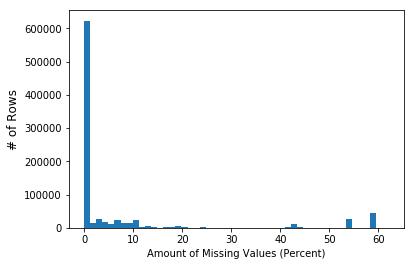

In [21]:
create_hist(per_missing_rows, 'Rows', 'Missing Values (Percent)')

In [22]:
# Write code to divide the data into two subsets based on the number of missing
# values in each row.

low_values = azdias_df[azdias_df.isnull().sum(axis=1) < 30]
high_values = azdias_df[azdias_df.isnull().sum(axis=1) >= 30]

display(low_values.head())
display(high_values.head())

,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,LP_FAMILIE_FEIN,LP_FAMILIE_GROB,LP_STATUS_FEIN,LP_STATUS_GROB,NATIONALITAET_KZ,PRAEGENDE_JUGENDJAHRE,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SHOPPER_TYP,SOHO_KZ,VERS_TYP,ZABEOTYP,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,GEBAEUDETYP,KONSUMNAEHE,MIN_GEBAEUDEJAHR,OST_WEST_KZ,WOHNLAGE,CAMEO_DEUG_2015,CAMEO_DEU_2015,CAMEO_INTL_2015,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
1,1.0,2,5.0,1,5,2,5,4,5,1,10.0,0,3.0,21.0,6.0,5.0,3.0,2.0,1.0,1.0,14.0,1.0,5,4,4,3,1,2,2,3,6,4,7,4,7,6,3.0,1.0,2.0,5,2.0,0.0,6.0,3.0,9.0,11.0,0.0,8.0,1.0,1992.0,W,4.0,8,8A,51,0.0,0.0,0.0,2.0,1.0,6.0,3.0,8.0,3.0,2.0,1.0,3.0,3.0,963.0,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,3.0,2,3.0,1,4,1,2,3,5,1,10.0,1,3.0,3.0,1.0,1.0,1.0,3.0,2.0,1.0,15.0,3.0,4,1,3,3,4,4,6,3,4,7,7,7,3,3,2.0,0.0,1.0,5,1.0,0.0,4.0,3.0,9.0,10.0,0.0,1.0,5.0,1992.0,W,2.0,4,4C,24,1.0,3.0,1.0,0.0,3.0,2.0,4.0,4.0,4.0,2.0,3.0,2.0,2.0,712.0,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,4.0,2,2.0,4,2,5,2,1,2,6,1.0,0,2.0,NaN,NaN,NaN,NaN,9.0,4.0,1.0,8.0,2.0,5,1,2,1,4,4,7,4,3,4,4,5,4,4,1.0,0.0,1.0,3,0.0,0.0,1.0,NaN,9.0,1.0,0.0,1.0,4.0,1997.0,W,7.0,2,2A,12,4.0,1.0,0.0,0.0,4.0,4.0,2.0,6.0,4.0,NaN,4.0,1.0,NaN,596.0,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,3.0,1,5.0,4,3,4,1,3,2,5,5.0,0,3.0,32.0,10.0,10.0,5.0,3.0,2.0,1.0,8.0,5.0,6,4,4,2,7,4,4,6,2,3,2,2,4,2,2.0,0.0,2.0,4,4.0,0.0,5.0,2.0,9.0,3.0,0.0,1.0,4.0,1992.0,W,3.0,6,6B,43,1.0,4.0,1.0,0.0,3.0,2.0,5.0,1.0,5.0,3.0,3.0,5.0,5.0,435.0,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0
5,1.0,2,2.0,3,1,5,2,2,5,2,1.0,0,3.0,8.0,2.0,1.0,1.0,4.0,2.0,1.0,3.0,3.0,2,4,7,4,2,2,2,5,7,4,4,4,7,6,0.0,0.0,2.0,4,1.0,0.0,5.0,6.0,9.0,5.0,0.0,1.0,5.0,1992.0,W,7.0,8,8C,54,2.0,2.0,0.0,0.0,4.0,6.0,2.0,7.0,4.0,4.0,4.0,1.0,5.0,1300.0,2.0,3.0,1.0,1.0,1.0,5.0,5.0,2.0,3.0,3.0


,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,LP_FAMILIE_FEIN,LP_FAMILIE_GROB,LP_STATUS_FEIN,LP_STATUS_GROB,NATIONALITAET_KZ,PRAEGENDE_JUGENDJAHRE,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SHOPPER_TYP,SOHO_KZ,VERS_TYP,ZABEOTYP,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,GEBAEUDETYP,KONSUMNAEHE,MIN_GEBAEUDEJAHR,OST_WEST_KZ,WOHNLAGE,CAMEO_DEUG_2015,CAMEO_DEU_2015,CAMEO_INTL_2015,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,2.0,1,2.0,3,4,3,5,5,3,4,10.0,0,NaN,15.0,4.0,2.0,2.0,1.0,1.0,NaN,NaN,5.0,2,6,7,5,1,5,3,3,4,7,6,6,5,3,NaN,NaN,NaN,3,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11,2.0,1,6.0,3,4,3,5,5,3,4,5.0,0,NaN,NaN,NaN,NaN,NaN,5.0,2.0,NaN,NaN,3.0,2,6,7,5,1,5,3,3,4,7,6,6,5,3,NaN,NaN,NaN,3,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
14,3.0,1,6.0,3,4,3,5,5,3,4,5.0,0,NaN,NaN,NaN,NaN,NaN,5.0,2.0,NaN,NaN,3.0,2,6,7,5,1,5,3,3,4,7,6,6,5,3,NaN,NaN,NaN,3,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
17,2.0,1,6.0,3,4,3,5,5,3,4,5.0,0,NaN,NaN,NaN,NaN,NaN,5.0,2.0,NaN,NaN,3.0,2,6,7,5,1,5,3,3,4,7,6,6,5,3,NaN,NaN,NaN,3,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
24,3.0,2,6.0,3,4,3,5,5,3,4,5.0,0,NaN,NaN,NaN,NaN,NaN,5.0,2.0,NaN,NaN,3.0,2,6,7,5,1,5,3,3,4,7,6,6,5,3,NaN,NaN,NaN,3,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [23]:
azdias_df = low_values

In [25]:
# Compare the distribution of values for at least five columns where there are
# no or few missing values, between the two subsets.

def compare_distributions(col_name):
    '''
    Creates two plots based on a specific column name within the subsets low_values and high_values.
    
    Parameters:
    col_name (str): The column name to plot.
    
    Returns:
    plt: Plotted variables.
    
    '''
    fig = plt.figure(figsize=(14,4))
    ax1 = fig.add_subplot(121)
    ax1.title.set_text('High amount of missing values')
    sns.countplot(high_values[col_name], palette = 'Set1')
    ax2 = fig.add_subplot(122)
    ax2.title.set_text('Low amount of missing values')
    sns.countplot(low_values[col_name], palette = 'Set2')
    fig.tight_layout()
    plt.show()

In [26]:
Cols_no = percent_missing[percent_missing == 0]
Cols_no = Cols_no.keys().tolist()

Cols_no

['ANREDE_KZ',
 'FINANZ_MINIMALIST',
 'FINANZ_SPARER',
 'FINANZ_VORSORGER',
 'FINANZ_ANLEGER',
 'FINANZ_UNAUFFAELLIGER',
 'FINANZ_HAUSBAUER',
 'FINANZTYP',
 'GREEN_AVANTGARDE',
 'SEMIO_SOZ',
 'SEMIO_FAM',
 'SEMIO_REL',
 'SEMIO_MAT',
 'SEMIO_VERT',
 'SEMIO_LUST',
 'SEMIO_ERL',
 'SEMIO_KULT',
 'SEMIO_RAT',
 'SEMIO_KRIT',
 'SEMIO_DOM',
 'SEMIO_KAEM',
 'SEMIO_PFLICHT',
 'SEMIO_TRADV',
 'ZABEOTYP']

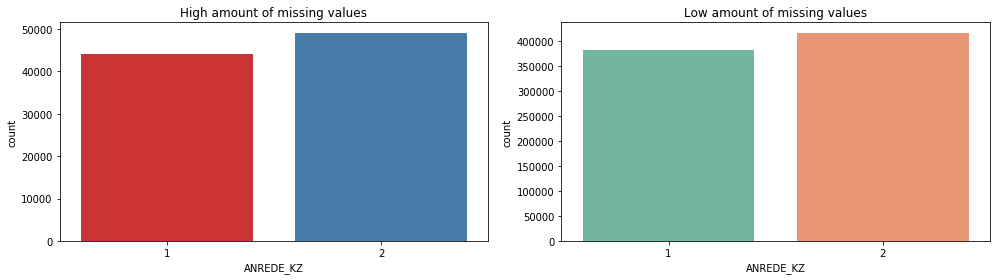

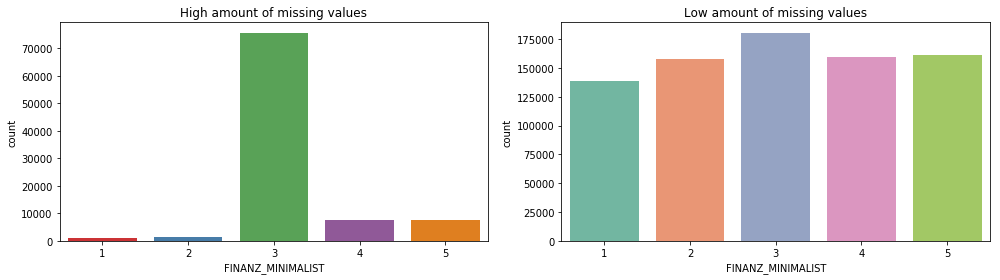

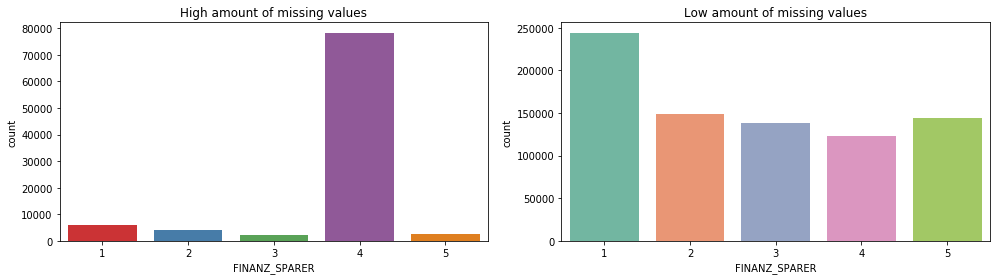

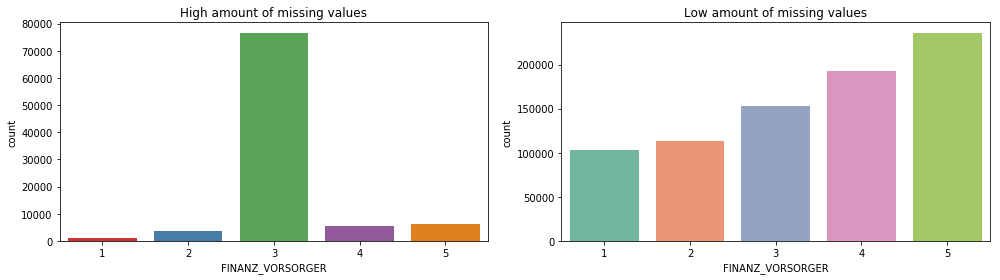

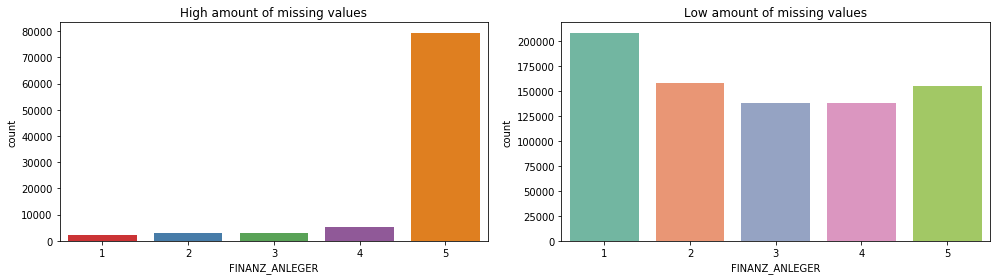

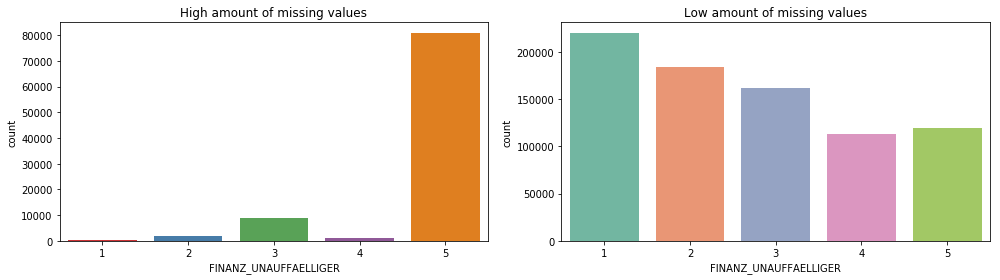

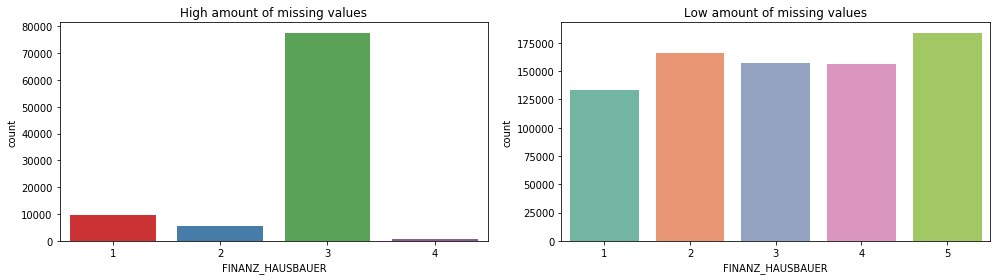

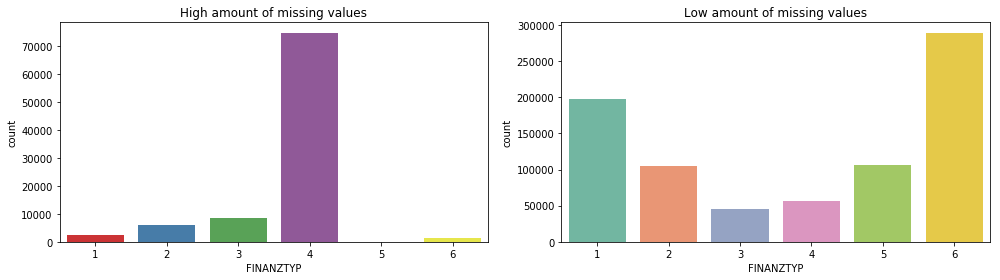

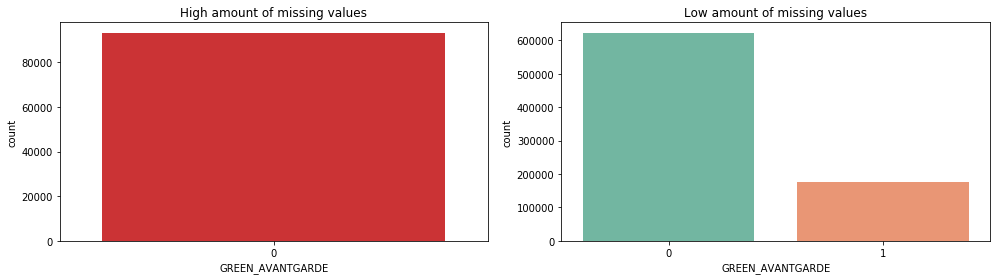

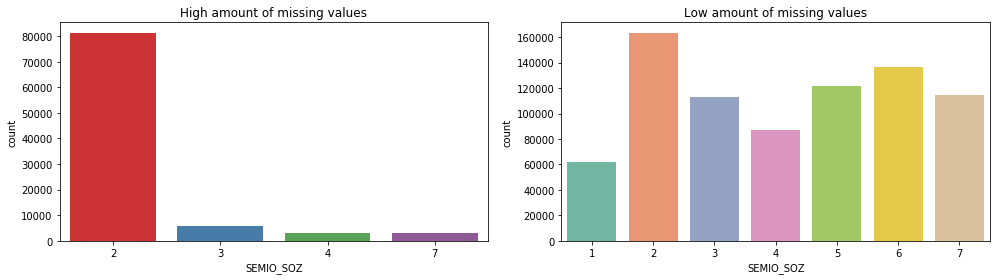

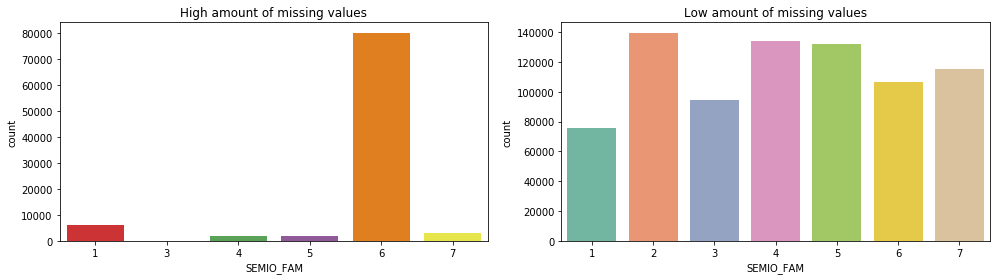

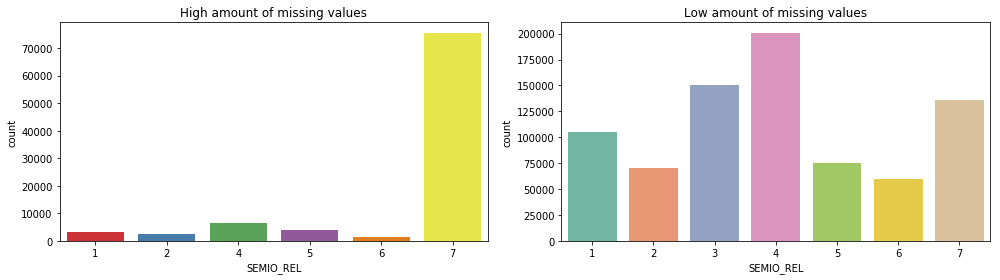

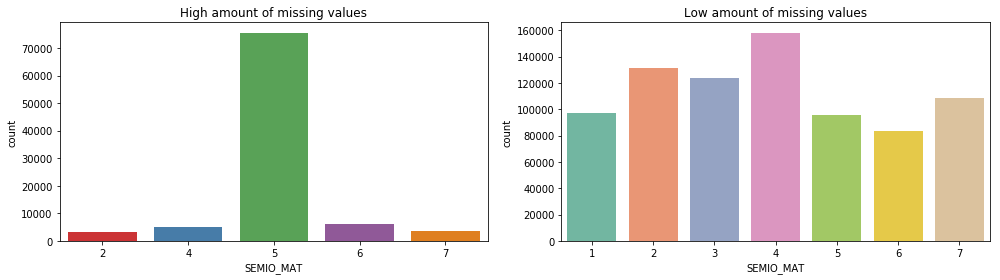

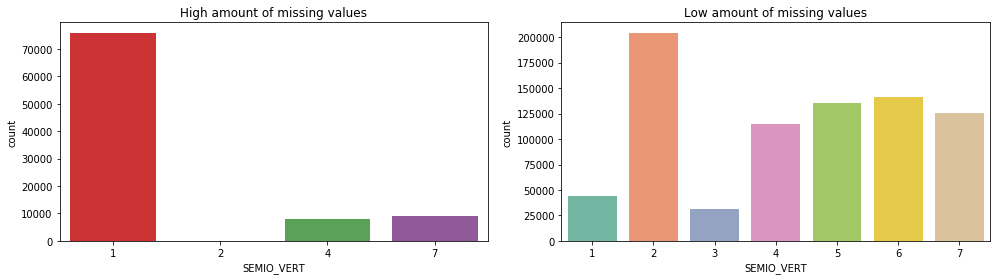

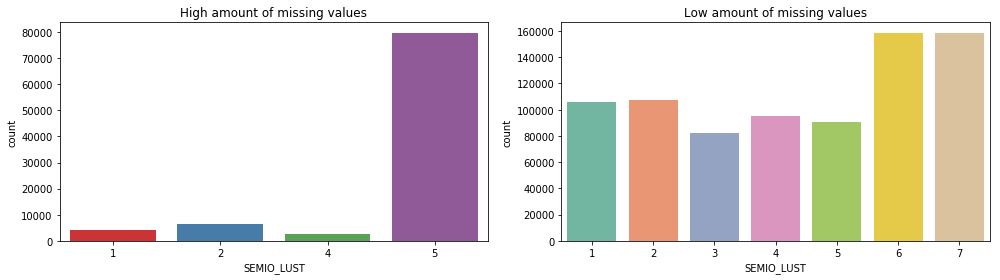

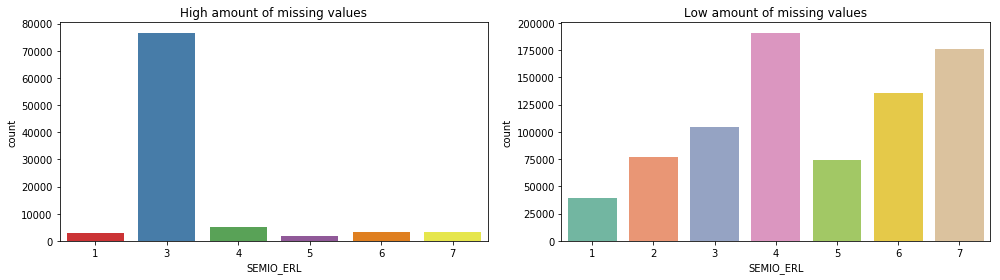

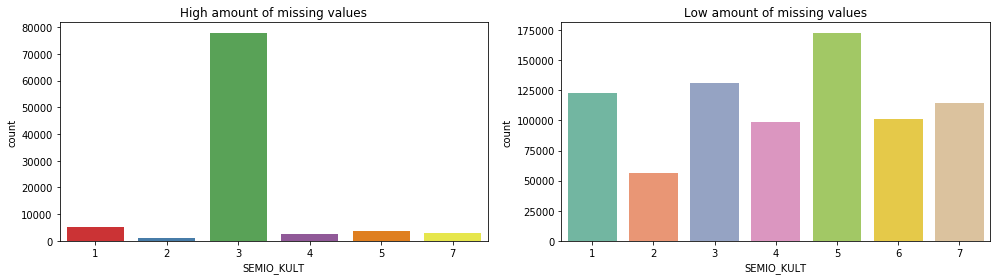

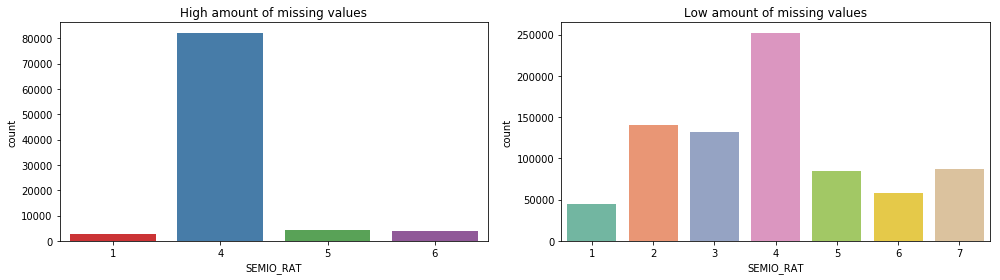

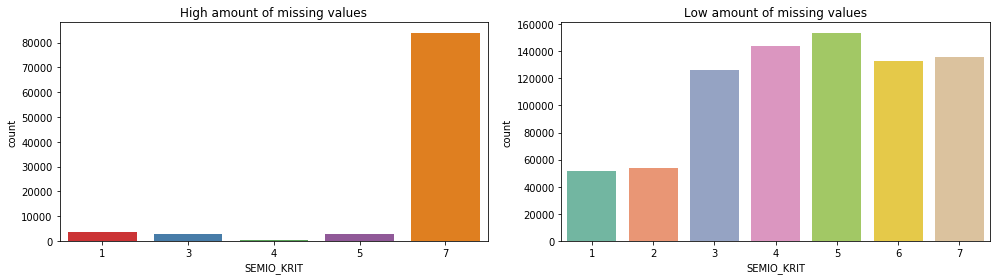

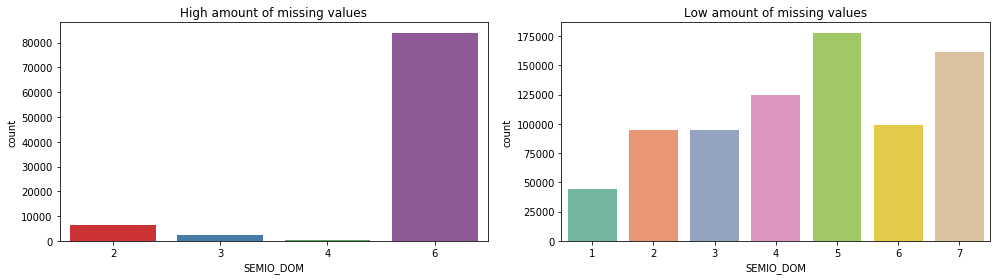

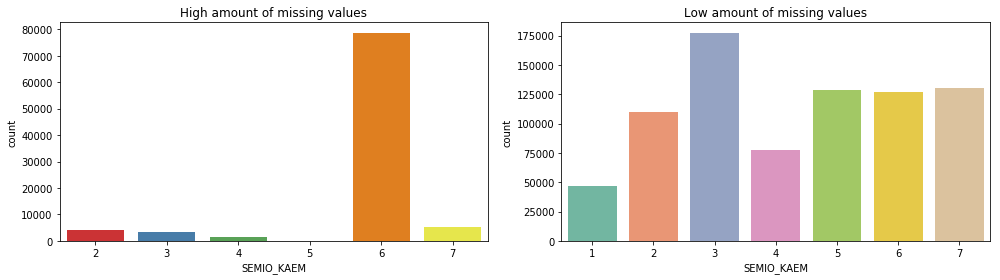

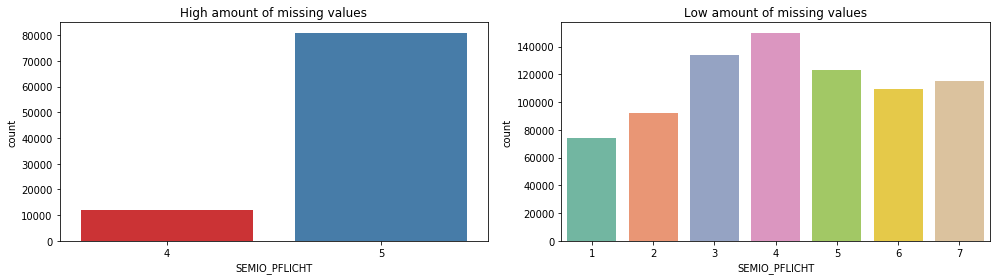

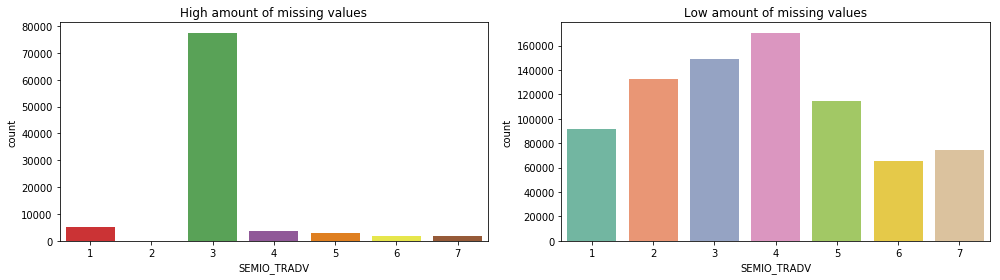

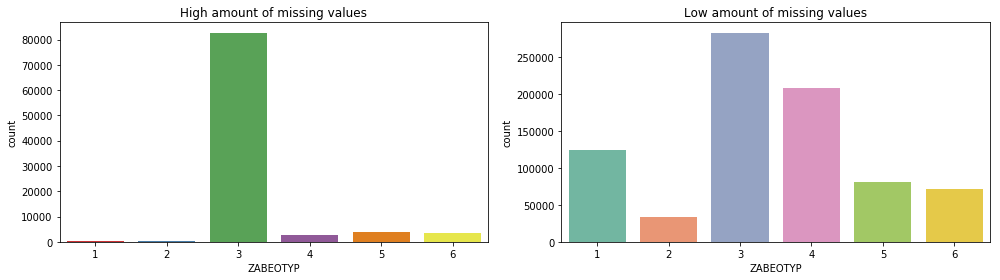

In [27]:
for column in Cols_no:
    compare_distributions(column)

#### Discussion 1.1.3: Assess Missing Data in Each Row

This reconfirms our decision to ensure that we use the data that has a low amount of missing data. High amounts of missing data can cause issues with how our model is trained. Keeping the columns that have high amounts of missing data would be detrimental to our analysis.

In addition, based on the comparisons, the high amount of missing data is considerably different than the low amount of missing data. It would be better to drop this data, as the large amount could negatively impact analysis results.

One last thing noticed is simply that they have the same types for each pair of data. But this is to be expected with the division of the subset.

In [28]:
High_Cols = high_values.keys().tolist()

High_vals = feat[feat['attribute'].isin(High_Cols)]

In [29]:
display(High_vals['type'].value_counts())

ordinal        49
categorical    18
mixed           6
numeric         6
Name: type, dtype: int64

In [30]:
Low_Cols = low_values.keys().tolist()

Low_vals = feat[feat['attribute'].isin(Low_Cols)]

In [31]:
display(Low_vals['type'].value_counts())

ordinal        49
categorical    18
mixed           6
numeric         6
Name: type, dtype: int64

### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

In [32]:
feat.head()

,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1, 0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1, 0, 9]"
2,ANREDE_KZ,person,categorical,"[-1, 0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]


In [33]:
# How many features are there of each data type?

feature_list = azdias_df.keys().tolist()
feature_list = feat[feat['attribute'].isin(feature_list)]
feature_list['type'].value_counts()

ordinal        49
categorical    18
mixed           6
numeric         6
Name: type, dtype: int64

#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

In [34]:
# Assess categorical variables: which are binary, which are multi-level.
# The multi-level variables need to be re-encoded

cat_features = feature_list[feature_list['type'] == 'categorical']['attribute']

In [35]:
display(cat_features.head())

2            ANREDE_KZ
3        CJT_GESAMTTYP
10           FINANZTYP
12     GFK_URLAUBERTYP
13    GREEN_AVANTGARDE
Name: attribute, dtype: object

In [36]:
# Collecting binary features and multi-level features
bi_features = []
multi_features = []

for feature in cat_features:
    if (azdias_df[feature].nunique() > 2):
        multi_features.append(feature)
    else:
        bi_features.append(feature)

In [37]:
display(multi_features)

['CJT_GESAMTTYP',
 'FINANZTYP',
 'GFK_URLAUBERTYP',
 'LP_FAMILIE_FEIN',
 'LP_FAMILIE_GROB',
 'LP_STATUS_FEIN',
 'LP_STATUS_GROB',
 'NATIONALITAET_KZ',
 'SHOPPER_TYP',
 'ZABEOTYP',
 'GEBAEUDETYP',
 'CAMEO_DEUG_2015',
 'CAMEO_DEU_2015']

In [38]:
low_values[multi_features].head()

,CJT_GESAMTTYP,FINANZTYP,GFK_URLAUBERTYP,LP_FAMILIE_FEIN,LP_FAMILIE_GROB,LP_STATUS_FEIN,LP_STATUS_GROB,NATIONALITAET_KZ,SHOPPER_TYP,ZABEOTYP,GEBAEUDETYP,CAMEO_DEUG_2015,CAMEO_DEU_2015
1,5.0,1,10.0,5.0,3.0,2.0,1.0,1.0,3.0,5,8.0,8,8A
2,3.0,1,10.0,1.0,1.0,3.0,2.0,1.0,2.0,5,1.0,4,4C
3,2.0,6,1.0,NaN,NaN,9.0,4.0,1.0,1.0,3,1.0,2,2A
4,5.0,5,5.0,10.0,5.0,3.0,2.0,1.0,2.0,4,1.0,6,6B
5,2.0,2,1.0,1.0,1.0,4.0,2.0,1.0,0.0,4,1.0,8,8C


In [39]:
for i in bi_features:
    print(azdias_df[i].value_counts())

2    416177
1    381884
Name: ANREDE_KZ, dtype: int64
0    622836
1    175225
Name: GREEN_AVANTGARDE, dtype: int64
0.0    791344
1.0      6717
Name: SOHO_KZ, dtype: int64
2.0    394238
1.0    367102
Name: VERS_TYP, dtype: int64
W    629520
O    168541
Name: OST_WEST_KZ, dtype: int64


In [40]:
for i in multi_features:
    print(azdias_df[i].value_counts())

4.0    198295
3.0    147220
2.0    141269
5.0    111114
6.0    102107
1.0     93311
Name: CJT_GESAMTTYP, dtype: int64
6    289061
1    197171
5    106332
2    104773
4     55922
3     44802
Name: FINANZTYP, dtype: int64
12.0    130261
10.0    102831
8.0      83030
11.0     75103
5.0      70501
4.0      60422
9.0      57131
3.0      53101
1.0      50659
2.0      43857
7.0      40681
6.0      25739
Name: GFK_URLAUBERTYP, dtype: int64
1.0     402556
10.0    128974
2.0      98555
11.0     48746
8.0      21780
7.0      19575
4.0      11574
5.0      11167
9.0      10452
6.0       8526
3.0       4688
Name: LP_FAMILIE_FEIN, dtype: int64
1.0    402556
5.0    188172
2.0     98555
4.0     49881
3.0     27429
Name: LP_FAMILIE_GROB, dtype: int64
1.0     206853
9.0     136353
10.0    111574
2.0     111118
4.0      73973
3.0      68918
6.0      28896
5.0      27592
8.0      18835
7.0       9204
Name: LP_STATUS_FEIN, dtype: int64
1.0    317971
2.0    170483
4.0    155188
5.0    111574
3.0     38100
Na

In [41]:
# Re-encode categorical variable(s) to be kept in the analysis.

azdias_df['VERS_TYP'].replace([2.0, 1.0], [1, 0], inplace=True)
azdias_df['OST_WEST_KZ'].replace(['W', 'O'], [1, 0], inplace=True)

In [42]:
azdias_df.shape

(798061, 79)

In [43]:
# Testing if we can re-encode the multi_features:
test_df = azdias_df

test_df = pd.get_dummies(test_df, columns=multi_features)

In [44]:
# Based on the size, the df is too large to pass to PCA.

test_df.shape

(798061, 194)

In [45]:
# Dropping because attempting to re-encode multi_features will result in too large of a dataset.

azdias_df = azdias_df.drop(multi_features, axis=1)

In [46]:
azdias_df.shape

(798061, 66)

#### Discussion 1.2.1: Re-Encode Categorical Features

The main thing that we have kept were the binary categorical features. These features only needed small changes for us to perform an effective analysis.

For the multi features, we ended up having to get rid of them. Attempting to re-encode them with dummies only caused the dataset to grow too large for us to perform PCA.

In [47]:
azdias_df.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,PRAEGENDE_JUGENDJAHRE,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SOHO_KZ,VERS_TYP,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,KONSUMNAEHE,MIN_GEBAEUDEJAHR,OST_WEST_KZ,WOHNLAGE,CAMEO_INTL_2015,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
1,1.0,2,1,5,2,5,4,5,0,3.0,21.0,6.0,14.0,1.0,5,4,4,3,1,2,2,3,6,4,7,4,7,6,1.0,1.0,2.0,0.0,6.0,3.0,9.0,11.0,0.0,1.0,1992.0,1,4.0,51,0.0,0.0,0.0,2.0,1.0,6.0,3.0,8.0,3.0,2.0,1.0,3.0,3.0,963.0,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,3.0,2,1,4,1,2,3,5,1,3.0,3.0,1.0,15.0,3.0,4,1,3,3,4,4,6,3,4,7,7,7,3,3,0.0,0.0,1.0,0.0,4.0,3.0,9.0,10.0,0.0,5.0,1992.0,1,2.0,24,1.0,3.0,1.0,0.0,3.0,2.0,4.0,4.0,4.0,2.0,3.0,2.0,2.0,712.0,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,4.0,2,4,2,5,2,1,2,0,2.0,NaN,NaN,8.0,2.0,5,1,2,1,4,4,7,4,3,4,4,5,4,4,0.0,0.0,0.0,0.0,1.0,NaN,9.0,1.0,0.0,4.0,1997.0,1,7.0,12,4.0,1.0,0.0,0.0,4.0,4.0,2.0,6.0,4.0,NaN,4.0,1.0,NaN,596.0,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,3.0,1,4,3,4,1,3,2,0,3.0,32.0,10.0,8.0,5.0,6,4,4,2,7,4,4,6,2,3,2,2,4,2,0.0,1.0,4.0,0.0,5.0,2.0,9.0,3.0,0.0,4.0,1992.0,1,3.0,43,1.0,4.0,1.0,0.0,3.0,2.0,5.0,1.0,5.0,3.0,3.0,5.0,5.0,435.0,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0
5,1.0,2,3,1,5,2,2,5,0,3.0,8.0,2.0,3.0,3.0,2,4,7,4,2,2,2,5,7,4,4,4,7,6,0.0,1.0,1.0,0.0,5.0,6.0,9.0,5.0,0.0,5.0,1992.0,1,7.0,54,2.0,2.0,0.0,0.0,4.0,6.0,2.0,7.0,4.0,4.0,4.0,1.0,5.0,1300.0,2.0,3.0,1.0,1.0,1.0,5.0,5.0,2.0,3.0,3.0


#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

In [48]:
mixed_features = feature_list[feature_list['type'] == 'mixed']['attribute']

In [49]:
mixed_features.head()

15      LP_LEBENSPHASE_FEIN
16      LP_LEBENSPHASE_GROB
22    PRAEGENDE_JUGENDJAHRE
56                 WOHNLAGE
59          CAMEO_INTL_2015
Name: attribute, dtype: object

**Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.**

-  1: 40s - war years (Mainstream, E+W)
-  2: 40s - reconstruction years (Avantgarde, E+W)
-  3: 50s - economic miracle (Mainstream, E+W)
-  4: 50s - milk bar / Individualisation (Avantgarde, E+W)
-  5: 60s - economic miracle (Mainstream, E+W)
-  6: 60s - generation 68 / student protestors (Avantgarde, W)
-  7: 60s - opponents to the building of the Wall (Avantgarde, E)
-  8: 70s - family orientation (Mainstream, E+W)
-  9: 70s - peace movement (Avantgarde, E+W)
- 10: 80s - Generation Golf (Mainstream, W)
- 11: 80s - ecological awareness (Avantgarde, W)
- 12: 80s - FDJ / communist party youth organisation (Mainstream, E)
- 13: 80s - Swords into ploughshares (Avantgarde, E)
- 14: 90s - digital media kids (Mainstream, E+W)
- 15: 90s - ecological awareness (Avantgarde, E+W)

Mainstream = 0
Avantgarde = 1

In [50]:
decade = {1:1, 2:1, 3:2, 4:2, 5:3, 6:3, 7:3, 8:4, 9:4, 10:5, 11:5, 12:5, 13:5, 14:6, 15:6}
movement = {1:0, 2:1, 3:0, 4:1, 5:0, 6:1, 7:1, 8:0, 9:1, 10:0, 11:1, 12:0, 13:1, 14:0, 15:1}

In [51]:
azdias_df['Decade'] = azdias_df['PRAEGENDE_JUGENDJAHRE']
azdias_df['Decade'].replace(decade, inplace = True)

In [52]:
azdias_df['Movement'] = azdias_df['PRAEGENDE_JUGENDJAHRE']
azdias_df['Movement'].replace(movement, inplace = True)

In [53]:
azdias_df.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,PRAEGENDE_JUGENDJAHRE,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SOHO_KZ,VERS_TYP,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,KONSUMNAEHE,MIN_GEBAEUDEJAHR,OST_WEST_KZ,WOHNLAGE,CAMEO_INTL_2015,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,Decade,Movement
1,1.0,2,1,5,2,5,4,5,0,3.0,21.0,6.0,14.0,1.0,5,4,4,3,1,2,2,3,6,4,7,4,7,6,1.0,1.0,2.0,0.0,6.0,3.0,9.0,11.0,0.0,1.0,1992.0,1,4.0,51,0.0,0.0,0.0,2.0,1.0,6.0,3.0,8.0,3.0,2.0,1.0,3.0,3.0,963.0,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0,6.0,0.0
2,3.0,2,1,4,1,2,3,5,1,3.0,3.0,1.0,15.0,3.0,4,1,3,3,4,4,6,3,4,7,7,7,3,3,0.0,0.0,1.0,0.0,4.0,3.0,9.0,10.0,0.0,5.0,1992.0,1,2.0,24,1.0,3.0,1.0,0.0,3.0,2.0,4.0,4.0,4.0,2.0,3.0,2.0,2.0,712.0,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0,6.0,1.0
3,4.0,2,4,2,5,2,1,2,0,2.0,NaN,NaN,8.0,2.0,5,1,2,1,4,4,7,4,3,4,4,5,4,4,0.0,0.0,0.0,0.0,1.0,NaN,9.0,1.0,0.0,4.0,1997.0,1,7.0,12,4.0,1.0,0.0,0.0,4.0,4.0,2.0,6.0,4.0,NaN,4.0,1.0,NaN,596.0,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0,4.0,0.0
4,3.0,1,4,3,4,1,3,2,0,3.0,32.0,10.0,8.0,5.0,6,4,4,2,7,4,4,6,2,3,2,2,4,2,0.0,1.0,4.0,0.0,5.0,2.0,9.0,3.0,0.0,4.0,1992.0,1,3.0,43,1.0,4.0,1.0,0.0,3.0,2.0,5.0,1.0,5.0,3.0,3.0,5.0,5.0,435.0,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0,4.0,0.0
5,1.0,2,3,1,5,2,2,5,0,3.0,8.0,2.0,3.0,3.0,2,4,7,4,2,2,2,5,7,4,4,4,7,6,0.0,1.0,1.0,0.0,5.0,6.0,9.0,5.0,0.0,5.0,1992.0,1,7.0,54,2.0,2.0,0.0,0.0,4.0,6.0,2.0,7.0,4.0,4.0,4.0,1.0,5.0,1300.0,2.0,3.0,1.0,1.0,1.0,5.0,5.0,2.0,3.0,3.0,2.0,0.0


**Investigate "CAMEO_INTL_2015" and engineer two new variables.**

*German CAMEO: Wealth / Life Stage Typology, mapped to international code*

- -1: unknown
- 11: Wealthy Households - Pre-Family Couples & Singles
- 12: Wealthy Households - Young Couples With Children
- 13: Wealthy Households - Families With School Age Children
- 14: Wealthy Households - Older Families &  Mature Couples
- 15: Wealthy Households - Elders In Retirement
- 21: Prosperous Households - Pre-Family Couples & Singles
- 22: Prosperous Households - Young Couples With Children
- 23: Prosperous Households - Families With School Age Children
- 24: Prosperous Households - Older Families & Mature Couples
- 25: Prosperous Households - Elders In Retirement
- 31: Comfortable Households - Pre-Family Couples & Singles
- 32: Comfortable Households - Young Couples With Children
- 33: Comfortable Households - Families With School Age Children
- 34: Comfortable Households - Older Families & Mature Couples
- 35: Comfortable Households - Elders In Retirement
- 41: Less Affluent Households - Pre-Family Couples & Singles
- 42: Less Affluent Households - Young Couples With Children
- 43: Less Affluent Households - Families With School Age Children
- 44: Less Affluent Households - Older Families & Mature Couples
- 45: Less Affluent Households - Elders In Retirement
- 51: Poorer Households - Pre-Family Couples & Singles
- 52: Poorer Households - Young Couples With Children
- 53: Poorer Households - Families With School Age Children
- 54: Poorer Households - Older Families & Mature Couples
- 55: Poorer Households - Elders In Retirement
- XX: unknown


In [54]:
wealth = {
    '11':1, '12':1, '13':1, '14':1, '15':1, 
    '21':2, '22':2, '23':2, '24':2, '25':2, 
    '31':3, '32':3, '33':3, '34':3, '35':3, 
    '41':4, '42':4, '43':4, '44':4, '45':4, 
    '51':5, '52':5, '53':5, '54':5, '55':5, 
}

life_stage ={
    '11':1, '12':2, '13':3, '14':4, '15':5, 
    '21':1, '22':2, '23':3, '24':4, '25':5, 
    '31':1, '32':2, '33':3, '34':4, '35':5, 
    '41':1, '42':2, '43':3, '44':4, '45':5, 
    '51':1, '52':2, '53':3, '54':4, '55':5, 
}

In [55]:
azdias_df['Wealth'] = azdias_df['CAMEO_INTL_2015']
azdias_df['Wealth'].replace(wealth, inplace = True)

In [56]:
azdias_df['Life_Stage'] = azdias_df['CAMEO_INTL_2015']
azdias_df['Life_Stage'].replace(life_stage, inplace = True)

In [57]:
azdias_df = azdias_df.drop(mixed_features, axis = 1)

In [58]:
azdias_df.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SOHO_KZ,VERS_TYP,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,KONSUMNAEHE,MIN_GEBAEUDEJAHR,OST_WEST_KZ,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,Decade,Movement,Wealth,Life_Stage
1,1.0,2,1,5,2,5,4,5,0,3.0,1.0,5,4,4,3,1,2,2,3,6,4,7,4,7,6,1.0,1.0,2.0,0.0,6.0,3.0,9.0,11.0,0.0,1.0,1992.0,1,0.0,0.0,0.0,2.0,1.0,6.0,3.0,8.0,3.0,2.0,1.0,3.0,3.0,963.0,2.0,3.0,2.0,1.0,5.0,4.0,3.0,5.0,4.0,6.0,0.0,5.0,1.0
2,3.0,2,1,4,1,2,3,5,1,3.0,3.0,4,1,3,3,4,4,6,3,4,7,7,7,3,3,0.0,0.0,1.0,0.0,4.0,3.0,9.0,10.0,0.0,5.0,1992.0,1,1.0,3.0,1.0,0.0,3.0,2.0,4.0,4.0,4.0,2.0,3.0,2.0,2.0,712.0,3.0,3.0,1.0,0.0,4.0,4.0,3.0,5.0,2.0,6.0,1.0,2.0,4.0
3,4.0,2,4,2,5,2,1,2,0,2.0,2.0,5,1,2,1,4,4,7,4,3,4,4,5,4,4,0.0,0.0,0.0,0.0,1.0,NaN,9.0,1.0,0.0,4.0,1997.0,1,4.0,1.0,0.0,0.0,4.0,4.0,2.0,6.0,4.0,NaN,4.0,1.0,NaN,596.0,2.0,2.0,2.0,0.0,3.0,4.0,2.0,3.0,3.0,4.0,0.0,1.0,2.0
4,3.0,1,4,3,4,1,3,2,0,3.0,5.0,6,4,4,2,7,4,4,6,2,3,2,2,4,2,0.0,1.0,4.0,0.0,5.0,2.0,9.0,3.0,0.0,4.0,1992.0,1,1.0,4.0,1.0,0.0,3.0,2.0,5.0,1.0,5.0,3.0,3.0,5.0,5.0,435.0,2.0,4.0,2.0,1.0,3.0,3.0,4.0,6.0,5.0,4.0,0.0,4.0,3.0
5,1.0,2,3,1,5,2,2,5,0,3.0,3.0,2,4,7,4,2,2,2,5,7,4,4,4,7,6,0.0,1.0,1.0,0.0,5.0,6.0,9.0,5.0,0.0,5.0,1992.0,1,2.0,2.0,0.0,0.0,4.0,6.0,2.0,7.0,4.0,4.0,4.0,1.0,5.0,1300.0,2.0,3.0,1.0,1.0,5.0,5.0,2.0,3.0,3.0,2.0,0.0,5.0,4.0


#### Discussion 1.2.2: Engineer Mixed-Type Features

For the mixed type features, the key was in checking the documentation. By going through the documentation, we could define parameters based on the mixed values provided. Then we could drop the original columns and keep the re-encoded columns.

In [59]:
display(decade, movement, wealth, life_stage)

{1: 1,
 2: 1,
 3: 2,
 4: 2,
 5: 3,
 6: 3,
 7: 3,
 8: 4,
 9: 4,
 10: 5,
 11: 5,
 12: 5,
 13: 5,
 14: 6,
 15: 6}

{1: 0,
 2: 1,
 3: 0,
 4: 1,
 5: 0,
 6: 1,
 7: 1,
 8: 0,
 9: 1,
 10: 0,
 11: 1,
 12: 0,
 13: 1,
 14: 0,
 15: 1}

{'11': 1,
 '12': 1,
 '13': 1,
 '14': 1,
 '15': 1,
 '21': 2,
 '22': 2,
 '23': 2,
 '24': 2,
 '25': 2,
 '31': 3,
 '32': 3,
 '33': 3,
 '34': 3,
 '35': 3,
 '41': 4,
 '42': 4,
 '43': 4,
 '44': 4,
 '45': 4,
 '51': 5,
 '52': 5,
 '53': 5,
 '54': 5,
 '55': 5}

{'11': 1,
 '12': 2,
 '13': 3,
 '14': 4,
 '15': 5,
 '21': 1,
 '22': 2,
 '23': 3,
 '24': 4,
 '25': 5,
 '31': 1,
 '32': 2,
 '33': 3,
 '34': 4,
 '35': 5,
 '41': 1,
 '42': 2,
 '43': 3,
 '44': 4,
 '45': 5,
 '51': 1,
 '52': 2,
 '53': 3,
 '54': 4,
 '55': 5}

#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

In [60]:
# If there are other re-engineering tasks you need to perform, make sure you
# take care of them here. (Dealing with missing data will come in step 2.1.)

azdias_df.dtypes

ALTERSKATEGORIE_GROB     float64
ANREDE_KZ                  int64
FINANZ_MINIMALIST          int64
FINANZ_SPARER              int64
FINANZ_VORSORGER           int64
FINANZ_ANLEGER             int64
FINANZ_UNAUFFAELLIGER      int64
FINANZ_HAUSBAUER           int64
GREEN_AVANTGARDE           int64
HEALTH_TYP               float64
RETOURTYP_BK_S           float64
SEMIO_SOZ                  int64
SEMIO_FAM                  int64
SEMIO_REL                  int64
SEMIO_MAT                  int64
SEMIO_VERT                 int64
SEMIO_LUST                 int64
SEMIO_ERL                  int64
SEMIO_KULT                 int64
SEMIO_RAT                  int64
SEMIO_KRIT                 int64
SEMIO_DOM                  int64
SEMIO_KAEM                 int64
SEMIO_PFLICHT              int64
SEMIO_TRADV                int64
SOHO_KZ                  float64
VERS_TYP                 float64
ANZ_PERSONEN             float64
ANZ_TITEL                float64
HH_EINKOMMEN_SCORE       float64
W_KEIT_KIN

In [61]:
# Do whatever you need to in order to ensure that the dataframe only contains
# the columns that should be passed to the algorithm functions.

feature_list = azdias_df.keys().tolist()
feature_list = feat[feat['attribute'].isin(feature_list)]
feature_list['type'].value_counts()

ordinal        49
numeric         6
categorical     5
Name: type, dtype: int64

In [62]:
def _Stat_(df):
    row_count = df.shape[0]
    null_vals = df[df.isnull().any(axis=1)]
    count_rows_with_nans = null_vals.shape[0]
    percent_nans = count_rows_with_nans * 100 / row_count
    
    print('All rows {}, Complete rows {}, Incomplete rows {} ({:0.2f}%)'.format(row_count,
                                                                      row_count - count_rows_with_nans,
                                                                      count_rows_with_nans,
                                                                      percent_nans))

In [63]:
_Stat_(azdias_df)

All rows 798061, Complete rows 623211, Incomplete rows 174850 (21.91%)


In [64]:
azdias_df = azdias_df.dropna()
azdias_df.shape[0]

623211

In [65]:
azdias_df.shape

(623211, 64)

In [66]:
# Verify that the dropped values are gone.

_Stat_(azdias_df)

All rows 623211, Complete rows 623211, Incomplete rows 0 (0.00%)


### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [67]:
def clean_data(df, feat):
    """
    Perform feature trimming, re-encoding, and engineering for demographics data
    
    Parameters:
    df (dataframe): Demographics DataFrame input.
    feat (dataframe): The features list that describes the dataframe.
    
    Returns:
    azdias_df (dataframe): Cleaned dataframe object.
    """
    
    # Put in code here to execute all main cleaning steps:
    # convert missing value codes into NaNs, ...
    if type(feat.missing_or_unknown[0]) == str:
        feat.missing_or_unknown = feat.missing_or_unknown.str.strip('[').str.strip(']').str.split(',')
    
    
    # Replace with NaNs all values in all columns of azdias as per mapping in feat_info
    cleaned_df = replace_with_null(df, feat, 'attribute', 'missing_or_unknown', non_num_indicators=['X', 'XX'])
    
    # remove selected columns and rows
    try:
        cleaned_df = cleaned_df.drop(columns_names, axis=1)
        cleaned_df = cleaned_df[cleaned_df.isnull().sum(axis=1) < 30]
    
    except Exception as excpt:
        print('Exception: Missing columns drop was unsuccessful')
        
    # select, re-encode, and engineer column values.
    try:
        cleaned_df['VERS_TYP'].replace([2.0, 1.0], [1, 0], inplace=True)
        cleaned_df['OST_WEST_KZ'].replace(['W', 'O'], [1, 0], inplace=True)
        cleaned_df['ANREDE_KZ'].replace([2, 1], [1, 0], inplace=True)
    except Exception as excpt2:
        print('Exception: First replacement unsuccessful')
    
    try:
        feature_list = cleaned_df.keys().tolist()
        feature_list = feat[feat['attribute'].isin(feature_list)]
        feature_list['type'].value_counts()
    except Exception as excpt3:
        print('Exception: Second replacement unsuccessful')
    
    try:
        cleaned_df = cleaned_df.drop(multi_features, axis=1)
    except Exception as excpt4:
        print('Exception: get_dummies unsuccessful')
        
    try:    
        cleaned_df['Decade'] = cleaned_df['PRAEGENDE_JUGENDJAHRE']
        cleaned_df['Decade'].replace(decade, inplace = True)
    
        cleaned_df['Movement'] = cleaned_df['PRAEGENDE_JUGENDJAHRE']
        cleaned_df['Movement'].replace(movement, inplace = True)
    except Exception as excpt5:
        print('Exception: PRAEGENDE_JUGENDJAHRE replacement unsuccessful')
        
    try:
        cleaned_df['Wealth'] = cleaned_df['CAMEO_INTL_2015']
        cleaned_df['Wealth'].replace(wealth, inplace = True)
    
        cleaned_df['Life_Stage'] = cleaned_df['CAMEO_INTL_2015']
        cleaned_df['Life_Stage'].replace(life_stage, inplace = True)
    except Exception as excpt6:
        print('Exception: CAMEO_INTL_2015 replacement unsuccessful')
    
    try:
        cleaned_df = cleaned_df.drop(mixed_features, axis = 1)
        cleaned_df = cleaned_df.dropna()
    except Exception as excpt7:
        print('Exception: Mixed features drop unsuccessful')
        
    copy = cleaned_df
    
    # Return the cleaned dataframe.
    _Stat_(cleaned_df)
    return cleaned_df, copy

In [141]:
def test_df(cleaned_df, comparison_df):
    assert cleaned_df.shape[0] == comparison_df.shape[0], "Clean_data function is not working properly, rows mismatch"
    assert cleaned_df.shape[1] == comparison_df.shape[1], "Clean_data function is not working properly, columns mismatch"
    print("Success: Passed all tests")

## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [Imputer](https://scikit-learn.org/0.16/modules/generated/sklearn.preprocessing.Imputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

In [142]:
# If you've not yet cleaned the dataset of all NaN values, then investigate and
# do that now.

azdias_general = pd.read_csv('Udacity_AZDIAS_Subset.csv', delimiter = ';')

In [143]:
azdias_general, azdias_copy = clean_data(azdias_general, feat)

All rows 623211, Complete rows 623211, Incomplete rows 0 (0.00%)


In [144]:
test_df(azdias_general, azdias_df)

Success: Passed all tests


In [72]:
# Apply feature scaling to the general population demographics data.

scaler = StandardScaler()
azdias_general = scaler.fit_transform(azdias_general)

### Discussion 2.1: Apply Feature Scaling

The dataset was read into azdias_general and then cleaned with the cleaning function. The function also reports if there are any incomplete rows, as well as reports the finished dataframe. This is so we can verify the correct shape of that the dataframe should be, as well as learn if there are any missing values still present.

After this cleaning, I applied the standardscaler and fit the scaler onto the azdias_general dataset.

In [73]:
display(azdias_general)

array([[-1.74628678,  0.97782483, -1.51222588, ..., -0.55367151,
         1.14788447, -1.25111082],
       [ 0.202108  ,  0.97782483, -1.51222588, ...,  1.80612507,
        -0.90999235,  0.74981994],
       [ 0.202108  , -1.02267806,  0.6924003 , ..., -0.55367151,
         0.46192553,  0.08284302],
       ..., 
       [-0.77208939,  0.97782483, -1.51222588, ..., -0.55367151,
        -0.22403341, -1.25111082],
       [-1.74628678, -1.02267806, -1.51222588, ..., -0.55367151,
         1.14788447, -1.25111082],
       [ 1.17630539, -1.02267806,  0.6924003 , ..., -0.55367151,
         0.46192553,  0.08284302]])

### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

In [74]:
# Reconfirm the correct shape of the dataset before applying PCA.

azdias_general.shape

(623211, 64)

In [75]:
# Apply PCA to the data.

pca = PCA()
azdias_pca = pca.fit(azdias_general)

In [76]:
# Investigate the variance accounted for by each principal component.

def scree_plot(pca, components_no=None, show_labels=False):
    '''
    Taken from Udacity course
    
    Parameters:
    pca
    components_no
    show_labels
    
    Returns:
    PCA plot
    '''
    vals = pca.explained_variance_ratio_
    if components_no:
        vals = vals[:components_no]
    num_components = len(vals)
    ind = np.arange(num_components)
 
    plt.figure(figsize=(18, 8))
    ax = plt.subplot(111)
    cumvals = np.cumsum(vals)
    ax.bar(ind, vals)
    ax.plot(ind, cumvals)
    
    if show_labels:
        for i in range(num_components):
            ax.annotate(r"%s%%" % ((str(vals[i]*100)[:4])), (ind[i]+0.2, vals[i]), va="bottom", ha="center", fontsize=12)
 
    ax.xaxis.set_tick_params(width=0)
    ax.yaxis.set_tick_params(width=2, length=12)
 
    ax.set_xlabel("Principal Component")
    ax.set_ylabel("Variance Explained (%)")
    plt.title('Explained Variance Per Principal Component')

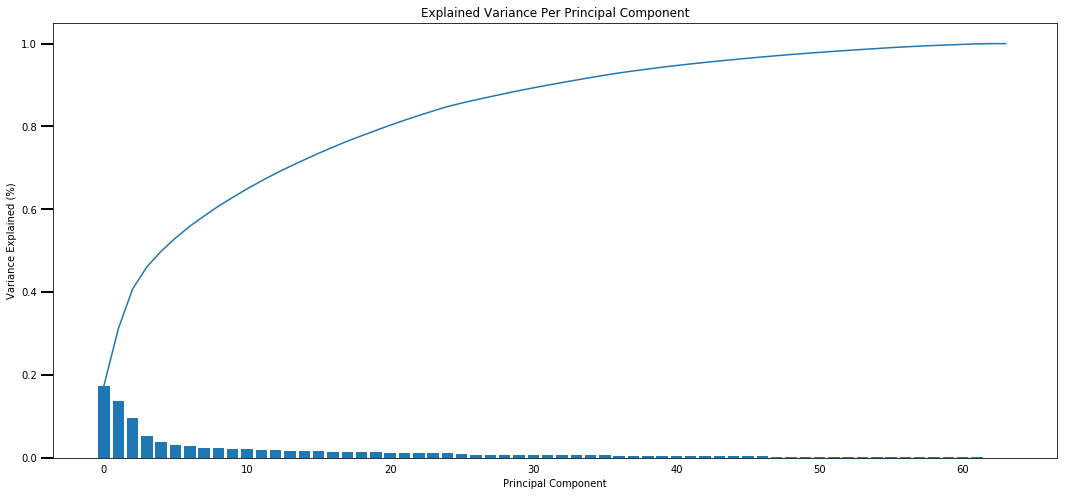

In [77]:
scree_plot(pca, show_labels=False)

In [78]:
# PCA with small number of components to test

pca = PCA(n_components=20)
azdias_pca_small = pca.fit_transform(azdias_general)

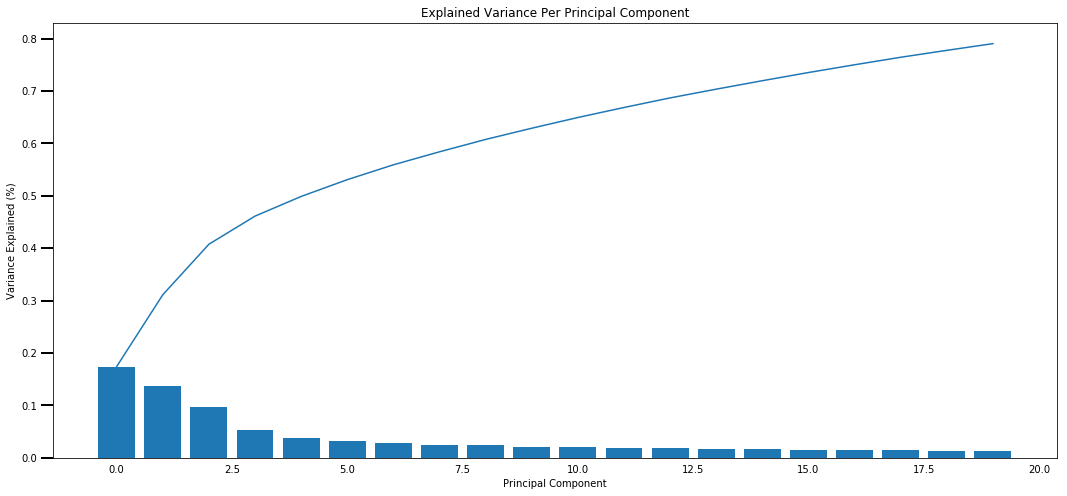

In [79]:
scree_plot(pca, components_no=20, show_labels=False)

In [80]:
# Re-apply PCA to the data while selecting for number of components to retain.

pca = PCA()
azdias_pca = pca.fit_transform(azdias_general)

### Discussion 2.2: Perform Dimensionality Reduction

I defined the scree_plot function from the previous Udacity lessons, as it is incredibly helpful in plotting out the PCA results. After applying PCA to the full dataset, versus the a small number of values, I believe that keeping the PCA for the full dataset is the best route. This is specifically because I had previously designed it to have a limited amount, so the full amount of principal components would be more beneficial rather than attempting to use a small subset.

In [81]:
display(azdias_pca)

array([[  4.08960791e+00,  -2.25071385e+00,  -2.95874798e+00, ...,
          2.04372934e-01,   1.24966259e-01,   7.70551825e-14],
       [ -1.05292884e+00,   4.39924378e-02,  -3.09667752e+00, ...,
          5.30447084e-02,  -5.58101965e-02,  -3.64976923e-13],
       [  4.46229155e-01,   2.01860129e-01,   3.20281103e+00, ...,
          4.88458140e-01,   3.46325513e-01,   2.65593381e-13],
       ..., 
       [  3.62284721e+00,  -1.63829513e+00,  -3.63672746e+00, ...,
          6.00875650e-01,  -1.69265997e-01,   3.14790249e-15],
       [  6.14666545e+00,  -2.70791460e+00,   2.18405501e+00, ...,
          4.15831776e-01,  -1.53183436e-01,  -5.98949887e-15],
       [ -8.50444780e-01,   8.82615161e-01,   2.93666634e+00, ...,
          7.54480282e-01,   2.43890335e-01,   7.29610164e-16]])

### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

In [82]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
# HINT: Try defining a function here or in a new cell that you can reuse in the
# other cells.

def pca_weight_stats(df, pca, i):
    _cols = azdias_copy.keys().tolist()
    weight_df = pd.DataFrame(pca.components_, columns=_cols)
    weights_ = weight_df.iloc[i].sort_values(ascending = False)
    return weights_, weight_df
    

In [83]:
weights_, weight_df = pca_weight_stats(azdias_df, pca, 1)

In [84]:
display(weights_)

ALTERSKATEGORIE_GROB     0.245187
SEMIO_ERL                0.224264
FINANZ_VORSORGER         0.213828
SEMIO_LUST               0.169071
RETOURTYP_BK_S           0.161124
FINANZ_HAUSBAUER         0.130939
SEMIO_KRIT               0.122087
W_KEIT_KIND_HH           0.119925
PLZ8_ANTG3               0.117823
SEMIO_KAEM               0.115433
PLZ8_ANTG4               0.112918
EWDICHTE                 0.110806
ORTSGR_KLS9              0.110599
Wealth                   0.092701
ANREDE_KZ                0.090215
ARBEIT                   0.083185
KBA05_ANTG4              0.082805
PLZ8_ANTG2               0.077961
RELAT_AB                 0.077828
ANZ_HAUSHALTE_AKTIV      0.073377
SEMIO_DOM                0.070563
HH_EINKOMMEN_SCORE       0.068501
KBA05_ANTG3              0.062075
WOHNDAUER_2008           0.052495
FINANZ_MINIMALIST        0.040815
ANZ_HH_TITEL             0.032877
REGIOTYP                 0.031267
VERS_TYP                 0.029860
PLZ8_HHZ                 0.014866
KKK           

In [85]:
display(weight_df.head())

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SOHO_KZ,VERS_TYP,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,KONSUMNAEHE,MIN_GEBAEUDEJAHR,OST_WEST_KZ,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,Decade,Movement,Wealth,Life_Stage
0,-0.147904,-0.003882,-0.222484,0.165815,-0.136351,0.087292,0.094742,0.144909,-0.115301,0.038563,-0.038517,0.052667,0.094596,0.131591,0.097790,-0.025192,-0.106024,-0.105163,0.092752,0.110212,-0.007376,0.013268,0.026914,0.134194,0.120266,-0.002061,0.018459,-0.077039,-0.005926,0.195056,0.023761,-0.069301,0.130111,0.030706,-0.156134,-0.034327,-0.060087,-0.218353,0.007874,0.131532,0.146316,-0.208101,-0.117021,0.181219,-0.154191,-0.110762,0.045747,-0.233061,-0.024036,0.072320,-0.078556,-0.215423,0.141629,0.213716,0.207551,0.035649,-0.162744,0.137236,0.184226,0.124980,0.126726,-0.115301,0.197156,-0.125977
1,0.245187,0.090215,0.040815,-0.217398,0.213828,-0.193506,-0.216888,0.130939,-0.030862,-0.048854,0.161124,-0.099298,-0.172196,-0.251535,-0.146230,-0.071703,0.169071,0.224264,-0.212143,-0.160649,0.122087,0.070563,0.115433,-0.225035,-0.218421,-0.002450,0.029860,-0.070339,0.006721,0.068501,0.119925,0.052495,0.073377,0.032877,-0.082885,-0.031164,-0.037311,-0.105502,-0.008138,0.062075,0.082805,-0.111169,-0.073053,0.110806,-0.091900,-0.052967,0.010722,-0.114832,-0.162885,0.031267,-0.045996,-0.116467,0.077961,0.117823,0.112918,0.014866,-0.092383,0.083185,0.110599,0.077828,-0.236761,-0.030862,0.092701,-0.017051
2,0.082354,-0.367635,0.156670,-0.101300,0.098247,-0.188284,-0.092779,-0.047402,0.050851,-0.010786,0.116013,0.263595,0.251414,0.076440,0.048771,0.348013,0.073296,-0.169771,0.231457,-0.219058,-0.268971,-0.312720,-0.337117,-0.076973,-0.086170,0.000487,0.020775,-0.005772,0.010450,-0.025997,0.094845,0.034884,0.026813,0.014529,-0.039301,-0.010529,-0.012423,-0.023550,-0.012048,0.007144,0.029293,-0.027819,-0.036916,0.049060,-0.044866,-0.031191,-0.016679,-0.030730,-0.055531,-0.005038,-0.021592,-0.046136,0.030340,0.045845,0.046401,0.006606,-0.037479,0.033020,0.048823,0.031362,-0.107608,0.050851,0.024853,-0.009342
3,-0.042267,0.042771,0.058340,-0.000438,-0.019887,-0.128428,0.088772,-0.101835,0.391572,0.003357,0.006125,-0.001483,-0.020618,-0.005386,0.024529,-0.014018,0.000168,-0.018828,-0.037116,0.055931,0.016641,0.116531,0.082500,0.019225,0.067383,0.001527,0.015875,0.095638,0.053077,-0.267435,-0.083118,0.006696,-0.020876,0.045559,-0.150074,-0.050282,0.105127,0.085447,-0.003348,-0.073993,-0.016901,0.041782,-0.240241,0.263704,-0.223009,-0.094898,-0.278435,0.050215,0.135659,-0.212012,0.039238,-0.054058,0.102482,0.099719,0.085562,0.129155,0.022814,0.050947,0.250306,0.093386,0.040798,0.391572,-0.130830,0.061196
4,-0.002339,-0.006189,-0.083350,-0.000054,0.059678,-0.048852,0.042764,0.086204,-0.057644,-0.009293,0.030245,-0.004634,0.034225,0.006772,0.066061,-0.002871,0.014491,-0.022716,-0.014260,0.011533,0.023757,-0.008866,-0.030074,0.000546,0.028872,-0.003516,-0.006492,-0.135394,0.002682,0.058894,0.124500,-0.041790,0.026599,0.027535,-0.122436,-0.089627,0.204708,-0.093560,0.121531,0.073914,0.002515,-0.089829,0.039373,-0.040660,0.076541,-0.057060,-0.138402,-0.098755,-0.113182,-0.091000,0.517372,0.022899,0.105426,0.030237,-0.015629,0.495550,0.397791,-0.206553,-0.089270,-0.139497,-0.032315,-0.057644,0.007773,-0.027239


In [86]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.

weights_, weight_df = pca_weight_stats(azdias_df, pca, 2)

In [87]:
display(weights_)

SEMIO_VERT               0.348013
SEMIO_SOZ                0.263595
SEMIO_FAM                0.251414
SEMIO_KULT               0.231457
FINANZ_MINIMALIST        0.156670
RETOURTYP_BK_S           0.116013
FINANZ_VORSORGER         0.098247
W_KEIT_KIND_HH           0.094845
ALTERSKATEGORIE_GROB     0.082354
SEMIO_REL                0.076440
SEMIO_LUST               0.073296
Movement                 0.050851
GREEN_AVANTGARDE         0.050851
EWDICHTE                 0.049060
ORTSGR_KLS9              0.048823
SEMIO_MAT                0.048771
PLZ8_ANTG4               0.046401
PLZ8_ANTG3               0.045845
WOHNDAUER_2008           0.034884
ARBEIT                   0.033020
RELAT_AB                 0.031362
PLZ8_ANTG2               0.030340
KBA05_ANTG4              0.029293
ANZ_HAUSHALTE_AKTIV      0.026813
Wealth                   0.024853
VERS_TYP                 0.020775
ANZ_HH_TITEL             0.014529
ANZ_TITEL                0.010450
KBA05_ANTG3              0.007144
PLZ8_HHZ      

In [88]:
display(weight_df.head())

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SOHO_KZ,VERS_TYP,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,KONSUMNAEHE,MIN_GEBAEUDEJAHR,OST_WEST_KZ,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,Decade,Movement,Wealth,Life_Stage
0,-0.147904,-0.003882,-0.222484,0.165815,-0.136351,0.087292,0.094742,0.144909,-0.115301,0.038563,-0.038517,0.052667,0.094596,0.131591,0.097790,-0.025192,-0.106024,-0.105163,0.092752,0.110212,-0.007376,0.013268,0.026914,0.134194,0.120266,-0.002061,0.018459,-0.077039,-0.005926,0.195056,0.023761,-0.069301,0.130111,0.030706,-0.156134,-0.034327,-0.060087,-0.218353,0.007874,0.131532,0.146316,-0.208101,-0.117021,0.181219,-0.154191,-0.110762,0.045747,-0.233061,-0.024036,0.072320,-0.078556,-0.215423,0.141629,0.213716,0.207551,0.035649,-0.162744,0.137236,0.184226,0.124980,0.126726,-0.115301,0.197156,-0.125977
1,0.245187,0.090215,0.040815,-0.217398,0.213828,-0.193506,-0.216888,0.130939,-0.030862,-0.048854,0.161124,-0.099298,-0.172196,-0.251535,-0.146230,-0.071703,0.169071,0.224264,-0.212143,-0.160649,0.122087,0.070563,0.115433,-0.225035,-0.218421,-0.002450,0.029860,-0.070339,0.006721,0.068501,0.119925,0.052495,0.073377,0.032877,-0.082885,-0.031164,-0.037311,-0.105502,-0.008138,0.062075,0.082805,-0.111169,-0.073053,0.110806,-0.091900,-0.052967,0.010722,-0.114832,-0.162885,0.031267,-0.045996,-0.116467,0.077961,0.117823,0.112918,0.014866,-0.092383,0.083185,0.110599,0.077828,-0.236761,-0.030862,0.092701,-0.017051
2,0.082354,-0.367635,0.156670,-0.101300,0.098247,-0.188284,-0.092779,-0.047402,0.050851,-0.010786,0.116013,0.263595,0.251414,0.076440,0.048771,0.348013,0.073296,-0.169771,0.231457,-0.219058,-0.268971,-0.312720,-0.337117,-0.076973,-0.086170,0.000487,0.020775,-0.005772,0.010450,-0.025997,0.094845,0.034884,0.026813,0.014529,-0.039301,-0.010529,-0.012423,-0.023550,-0.012048,0.007144,0.029293,-0.027819,-0.036916,0.049060,-0.044866,-0.031191,-0.016679,-0.030730,-0.055531,-0.005038,-0.021592,-0.046136,0.030340,0.045845,0.046401,0.006606,-0.037479,0.033020,0.048823,0.031362,-0.107608,0.050851,0.024853,-0.009342
3,-0.042267,0.042771,0.058340,-0.000438,-0.019887,-0.128428,0.088772,-0.101835,0.391572,0.003357,0.006125,-0.001483,-0.020618,-0.005386,0.024529,-0.014018,0.000168,-0.018828,-0.037116,0.055931,0.016641,0.116531,0.082500,0.019225,0.067383,0.001527,0.015875,0.095638,0.053077,-0.267435,-0.083118,0.006696,-0.020876,0.045559,-0.150074,-0.050282,0.105127,0.085447,-0.003348,-0.073993,-0.016901,0.041782,-0.240241,0.263704,-0.223009,-0.094898,-0.278435,0.050215,0.135659,-0.212012,0.039238,-0.054058,0.102482,0.099719,0.085562,0.129155,0.022814,0.050947,0.250306,0.093386,0.040798,0.391572,-0.130830,0.061196
4,-0.002339,-0.006189,-0.083350,-0.000054,0.059678,-0.048852,0.042764,0.086204,-0.057644,-0.009293,0.030245,-0.004634,0.034225,0.006772,0.066061,-0.002871,0.014491,-0.022716,-0.014260,0.011533,0.023757,-0.008866,-0.030074,0.000546,0.028872,-0.003516,-0.006492,-0.135394,0.002682,0.058894,0.124500,-0.041790,0.026599,0.027535,-0.122436,-0.089627,0.204708,-0.093560,0.121531,0.073914,0.002515,-0.089829,0.039373,-0.040660,0.076541,-0.057060,-0.138402,-0.098755,-0.113182,-0.091000,0.517372,0.022899,0.105426,0.030237,-0.015629,0.495550,0.397791,-0.206553,-0.089270,-0.139497,-0.032315,-0.057644,0.007773,-0.027239


In [89]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.

weights_, weight_df = pca_weight_stats(azdias_df, pca, 3)

In [90]:
display(weights_)

Movement                 0.391572
GREEN_AVANTGARDE         0.391572
EWDICHTE                 0.263704
ORTSGR_KLS9              0.250306
ONLINE_AFFINITAET        0.135659
PLZ8_HHZ                 0.129155
SEMIO_DOM                0.116531
OST_WEST_KZ              0.105127
PLZ8_ANTG2               0.102482
PLZ8_ANTG3               0.099719
ANZ_PERSONEN             0.095638
RELAT_AB                 0.093386
FINANZ_UNAUFFAELLIGER    0.088772
PLZ8_ANTG4               0.085562
KBA05_ANTG1              0.085447
SEMIO_KAEM               0.082500
SEMIO_TRADV              0.067383
Life_Stage               0.061196
FINANZ_MINIMALIST        0.058340
SEMIO_RAT                0.055931
ANZ_TITEL                0.053077
ARBEIT                   0.050947
MOBI_REGIO               0.050215
ANZ_HH_TITEL             0.045559
ANREDE_KZ                0.042771
KBA05_GBZ                0.041782
Decade                   0.040798
KBA13_ANZAHL_PKW         0.039238
SEMIO_MAT                0.024529
PLZ8_GBZ      

In [91]:
display(weight_df.head())

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SOHO_KZ,VERS_TYP,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,KONSUMNAEHE,MIN_GEBAEUDEJAHR,OST_WEST_KZ,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,Decade,Movement,Wealth,Life_Stage
0,-0.147904,-0.003882,-0.222484,0.165815,-0.136351,0.087292,0.094742,0.144909,-0.115301,0.038563,-0.038517,0.052667,0.094596,0.131591,0.097790,-0.025192,-0.106024,-0.105163,0.092752,0.110212,-0.007376,0.013268,0.026914,0.134194,0.120266,-0.002061,0.018459,-0.077039,-0.005926,0.195056,0.023761,-0.069301,0.130111,0.030706,-0.156134,-0.034327,-0.060087,-0.218353,0.007874,0.131532,0.146316,-0.208101,-0.117021,0.181219,-0.154191,-0.110762,0.045747,-0.233061,-0.024036,0.072320,-0.078556,-0.215423,0.141629,0.213716,0.207551,0.035649,-0.162744,0.137236,0.184226,0.124980,0.126726,-0.115301,0.197156,-0.125977
1,0.245187,0.090215,0.040815,-0.217398,0.213828,-0.193506,-0.216888,0.130939,-0.030862,-0.048854,0.161124,-0.099298,-0.172196,-0.251535,-0.146230,-0.071703,0.169071,0.224264,-0.212143,-0.160649,0.122087,0.070563,0.115433,-0.225035,-0.218421,-0.002450,0.029860,-0.070339,0.006721,0.068501,0.119925,0.052495,0.073377,0.032877,-0.082885,-0.031164,-0.037311,-0.105502,-0.008138,0.062075,0.082805,-0.111169,-0.073053,0.110806,-0.091900,-0.052967,0.010722,-0.114832,-0.162885,0.031267,-0.045996,-0.116467,0.077961,0.117823,0.112918,0.014866,-0.092383,0.083185,0.110599,0.077828,-0.236761,-0.030862,0.092701,-0.017051
2,0.082354,-0.367635,0.156670,-0.101300,0.098247,-0.188284,-0.092779,-0.047402,0.050851,-0.010786,0.116013,0.263595,0.251414,0.076440,0.048771,0.348013,0.073296,-0.169771,0.231457,-0.219058,-0.268971,-0.312720,-0.337117,-0.076973,-0.086170,0.000487,0.020775,-0.005772,0.010450,-0.025997,0.094845,0.034884,0.026813,0.014529,-0.039301,-0.010529,-0.012423,-0.023550,-0.012048,0.007144,0.029293,-0.027819,-0.036916,0.049060,-0.044866,-0.031191,-0.016679,-0.030730,-0.055531,-0.005038,-0.021592,-0.046136,0.030340,0.045845,0.046401,0.006606,-0.037479,0.033020,0.048823,0.031362,-0.107608,0.050851,0.024853,-0.009342
3,-0.042267,0.042771,0.058340,-0.000438,-0.019887,-0.128428,0.088772,-0.101835,0.391572,0.003357,0.006125,-0.001483,-0.020618,-0.005386,0.024529,-0.014018,0.000168,-0.018828,-0.037116,0.055931,0.016641,0.116531,0.082500,0.019225,0.067383,0.001527,0.015875,0.095638,0.053077,-0.267435,-0.083118,0.006696,-0.020876,0.045559,-0.150074,-0.050282,0.105127,0.085447,-0.003348,-0.073993,-0.016901,0.041782,-0.240241,0.263704,-0.223009,-0.094898,-0.278435,0.050215,0.135659,-0.212012,0.039238,-0.054058,0.102482,0.099719,0.085562,0.129155,0.022814,0.050947,0.250306,0.093386,0.040798,0.391572,-0.130830,0.061196
4,-0.002339,-0.006189,-0.083350,-0.000054,0.059678,-0.048852,0.042764,0.086204,-0.057644,-0.009293,0.030245,-0.004634,0.034225,0.006772,0.066061,-0.002871,0.014491,-0.022716,-0.014260,0.011533,0.023757,-0.008866,-0.030074,0.000546,0.028872,-0.003516,-0.006492,-0.135394,0.002682,0.058894,0.124500,-0.041790,0.026599,0.027535,-0.122436,-0.089627,0.204708,-0.093560,0.121531,0.073914,0.002515,-0.089829,0.039373,-0.040660,0.076541,-0.057060,-0.138402,-0.098755,-0.113182,-0.091000,0.517372,0.022899,0.105426,0.030237,-0.015629,0.495550,0.397791,-0.206553,-0.089270,-0.139497,-0.032315,-0.057644,0.007773,-0.027239


### Discussion 2.3: Interpret Principal Components

(Double-click this cell and replace this text with your own text, reporting your observations from detailed investigation of the first few principal components generated. Can we interpret positive and negative values from them in a meaningful way?)

##### With the first principal component, the top three it was positively associated with were:

ALTERSKATEGORIE_GROB:  0.256265
<br>
(Estimated age based on given name analysis)

SEMIO_ERL:             0.229915
<br>
(Personality typology: ERL: event-oriented)

FINANZ_VORSORGER:      0.229239
<br>
(Financial typology: VORSORGER: be prepared)


##### The bottom three it was negatively associated with were:

FINANZ_SPARER:          -0.231660
<br>
(Financial typology: SPARER: money-saver)

Decade:                 -0.238553
<br>
(Decade with the person's youth)

SEMIO_REL:              -0.253635
<br>
(Personality typology: REL: religious)

##### Summary

These results mainly indicate that the first component is influenced more by the estimated age, the event-oriented personality, and the financial preparation of an individual.

##### With the second principal component, our top three were:

SEMIO_VERT:              0.344663
<br>
(Personality typology: VERT: dreamful)

SEMIO_SOZ:               0.261933
<br>
(Personality typology: SOZ: socially-minded)

SEMIO_FAM:               0.248836
<br>
(Personality typology: FAM: family-minded)

##### The bottom three it was negatively associated with were:

SEMIO_DOM:               -0.313070
<br>
(Personality typology: DOM: dominant-minded)

SEMIO_KAEM:              -0.335050
<br>
(Personality typology: KAEM: combative attitude)

ANREDE_KZ:               -0.367353
<br>
(Gender)

##### Summary
These results indicate that the second component is mainly influenced by three specific personality typologies: dreamful, socially-minded, and family-minded. Interestingly enough, there are two personality typologies that are in the bottom: dominant-minded and combative attitude.

##### With the third principal component, our top three were:

Movement:                0.400759
<br>
(Dominating movement of person's youth (avantgarde vs. mainstream))

GREEN_AVANTGARDE:        0.400759
<br>
(Membership in environmental sustainability as part of youth)

EWDICHTE:                0.261042
<br>
(Density of households per square kilometer)

##### The bottom three it was negatively associated with were:

BALLRAUM:               -0.234090
<br>
(Distance to nearest urban center)

HH_EINKOMMEN_SCORE:     -0.240016
<br>
(Estimated household net income)

KKK:                    -0.274666
<br>
(Purchasing power in region)

##### Summary
The third principal component is especially different. While the other two had some type of personality typology in the top, the main items influencing this component are: the Movement, the membership in environmental sustainability, and the density of households. This is an interesting change from the trends of the other two components. 

## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

In [92]:
# Over a number of different cluster counts...
cluster_count = [2, 4, 6, 8, 10, 12, 14, 16, 18, 20]
# run k-means clustering on the data and...
avg = []
for x in cluster_count:
    print('Start')
    kmeans = KMeans(n_clusters = x)
    print(f'kmeans {x} complete')
    model = kmeans.fit(azdias_pca)
    print(f'model {x} complete')
    # compute the average within-cluster distances.
    num = np.abs(model.score(azdias_pca))
    avg.append(num)
    print(f'Round {x} complete')

Start
kmeans 2 complete
model 2 complete
Round 2 complete
Start
kmeans 4 complete
model 4 complete
Round 4 complete
Start
kmeans 6 complete
model 6 complete
Round 6 complete
Start
kmeans 8 complete
model 8 complete
Round 8 complete
Start
kmeans 10 complete
model 10 complete
Round 10 complete
Start
kmeans 12 complete
model 12 complete
Round 12 complete
Start
kmeans 14 complete
model 14 complete
Round 14 complete
Start
kmeans 16 complete
model 16 complete
Round 16 complete
Start
kmeans 18 complete
model 18 complete
Round 18 complete
Start
kmeans 20 complete
model 20 complete
Round 20 complete


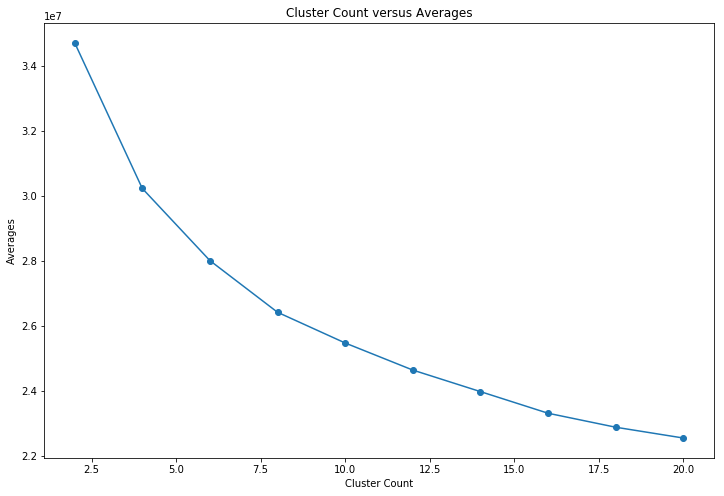

In [93]:
# Investigate the change in within-cluster distance across number of clusters.
# HINT: Use matplotlib's plot function to visualize this relationship.
plt.figure(figsize=(12,8))
plt.plot(cluster_count, avg, marker = 'o')
plt.xlabel('Cluster Count')
plt.ylabel('Averages')
plt.title('Cluster Count versus Averages')
plt.show()

In [94]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.
sel_num = 12

kmeans = KMeans(n_clusters = sel_num)
model = kmeans.fit(azdias_pca)
predictions = model.predict(azdias_pca)

### Discussion 3.1: Apply Clustering to General Population


I decided to segment the population into ten numbers, each multiples of 2. This spread would allow us to use the elbow method and find where the rate of variance sharply decreases visually. Based on this method, it appears that the area is around the 12th cluster.

### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [95]:
# Load in the customer demographics data.
customers = pd.read_csv('Udacity_CUSTOMERS_Subset.csv', delimiter = ';')

In [96]:
customers.head()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,GEBURTSJAHR,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,LP_FAMILIE_FEIN,LP_FAMILIE_GROB,LP_STATUS_FEIN,LP_STATUS_GROB,NATIONALITAET_KZ,PRAEGENDE_JUGENDJAHRE,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SHOPPER_TYP,SOHO_KZ,TITEL_KZ,VERS_TYP,ZABEOTYP,ALTER_HH,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,KK_KUNDENTYP,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,GEBAEUDETYP,KONSUMNAEHE,MIN_GEBAEUDEJAHR,OST_WEST_KZ,WOHNLAGE,CAMEO_DEUG_2015,CAMEO_DEU_2015,CAMEO_INTL_2015,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_BAUMAX,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,2,4,1,5.0,5,1,5,1,2,2,2,0,4.0,1,1,20.0,5.0,2.0,2.0,10.0,5.0,1,4,5.0,6,5,2,6,6,7,3,4,1,3,1,1,2,1,3,0.0,0.0,1,3,10.0,2.0,0.0,1.0,NaN,6.0,9.0,1.0,0.0,1.0,5.0,1992.0,W,7.0,1,1A,13,2.0,2.0,0.0,0.0,0.0,4.0,3.0,2.0,4.0,4.0,1.0,4.0,3.0,1.0,1201.0,3.0,3.0,1.0,0.0,1.0,5.0,5.0,1.0,2.0,1.0
1,-1,4,1,NaN,5,1,5,1,3,2,2,0,NaN,0,1,NaN,NaN,NaN,NaN,NaN,NaN,1,0,NaN,3,6,2,6,7,5,3,4,1,3,3,2,4,1,3,0.0,0.0,1,3,11.0,3.0,0.0,NaN,NaN,0.0,9.0,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,-1,4,2,2.0,5,1,5,1,4,4,2,0,3.0,1,2,13.0,3.0,1.0,1.0,10.0,5.0,1,4,5.0,2,2,1,3,3,7,7,1,2,7,5,6,4,1,1,0.0,0.0,2,3,6.0,1.0,0.0,1.0,NaN,6.0,9.0,1.0,0.0,8.0,1.0,1992.0,W,2.0,5,5D,34,2.0,2.0,0.0,0.0,0.0,3.0,7.0,4.0,1.0,3.0,3.0,3.0,1.0,7.0,433.0,2.0,3.0,3.0,1.0,3.0,3.0,2.0,3.0,5.0,3.0
3,1,4,1,2.0,5,1,5,2,1,2,6,0,10.0,0,2,0.0,0.0,0.0,0.0,9.0,4.0,1,1,3.0,6,5,3,4,7,5,3,4,3,3,3,3,3,4,0,0.0,0.0,1,1,8.0,0.0,0.0,4.0,NaN,NaN,9.0,0.0,NaN,2.0,2.0,1992.0,W,7.0,4,4C,24,3.0,0.0,0.0,0.0,1.0,4.0,7.0,1.0,7.0,4.0,3.0,4.0,2.0,6.0,755.0,3.0,2.0,1.0,0.0,1.0,3.0,4.0,1.0,3.0,1.0
4,-1,3,1,6.0,3,1,4,4,5,2,2,1960,2.0,0,3,31.0,10.0,10.0,5.0,1.0,1.0,1,8,5.0,4,5,4,6,5,6,4,5,5,3,5,2,5,4,1,0.0,0.0,2,1,20.0,4.0,0.0,6.0,2.0,2.0,9.0,7.0,0.0,3.0,1.0,1992.0,W,3.0,7,7B,41,0.0,3.0,2.0,0.0,0.0,3.0,3.0,4.0,4.0,3.0,4.0,3.0,5.0,7.0,513.0,2.0,4.0,2.0,1.0,2.0,3.0,3.0,3.0,5.0,1.0


In [97]:
# Apply preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data.

customers_cleaned, customers_copy = clean_data(customers, feat)

All rows 115643, Complete rows 115643, Incomplete rows 0 (0.00%)


In [103]:
# Scaler
customers_normalize = scaler.transform(customers_cleaned)

In [104]:
# PCA
customers_pca = pca.transform(customers_normalize)

In [105]:
# Clusters
customer_clusters = kmeans.predict(customers_pca)

### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

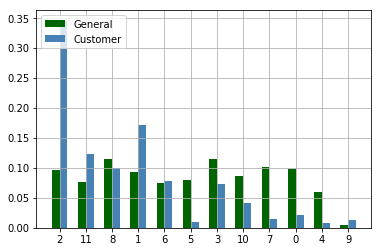

In [137]:
from collections import Counter

# generating proportion for the customer clusters.
labels, values = zip(*Counter(customer_clusters).items())
v=list(values)
v[:] = [x/len(customer_clusters) for x in v]
indexes = np.arange(len(labels))

# generating proportion for the azdias clusters.
labels1, values1 = zip(*Counter(predictions).items())
v1=list(values1)
v1[:] = [x/len(predictions) for x in v1]
indexes1 = np.arange(len(labels))
# configuring the graph

width = 0.3
plt.bar(indexes1, v1, width , color='darkgreen', label='General')
plt.bar(indexes + width, v, width,  color='steelblue' , label='Customer')
plt.xticks(indexes + width * 0.5, labels)
plt.legend(loc='upper left')
plt.grid()
plt.show()

In [121]:
azdias_cols_ = azdias_copy.keys().tolist()

In [138]:
# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?

cluster_2 = model.cluster_centers_[2]
pca_2 = pca.inverse_transform(cluster_2)
overrepresented = scaler.inverse_transform(pca_2)

In [139]:
overrepresented = pd.Series(data= overrepresented, index= azdias_cols_)

display(overrepresented.sort_values(ascending = False))

MIN_GEBAEUDEJAHR         1.992590e+03
KBA13_ANZAHL_PKW         6.925226e+02
WOHNDAUER_2008           8.519090e+00
SEMIO_VERT               6.153206e+00
SEMIO_LUST               5.352776e+00
ORTSGR_KLS9              5.327724e+00
SEMIO_KULT               5.043991e+00
SEMIO_SOZ                4.953133e+00
FINANZ_MINIMALIST        4.713453e+00
INNENSTADT               4.659831e+00
SEMIO_FAM                4.531757e+00
FINANZ_VORSORGER         4.236042e+00
MOBI_REGIO               4.165229e+00
W_KEIT_KIND_HH           4.105575e+00
KBA05_GBZ                4.095623e+00
BALLRAUM                 4.025554e+00
SEMIO_ERL                4.013169e+00
RETOURTYP_BK_S           3.974466e+00
EWDICHTE                 3.973541e+00
GEBAEUDETYP_RASTER       3.956753e+00
PLZ8_GBZ                 3.899290e+00
SEMIO_MAT                3.800249e+00
SEMIO_REL                3.784486e+00
PLZ8_HHZ                 3.678911e+00
Life_Stage               3.632909e+00
Decade                   3.555120e+00
SEMIO_DOM   

In [128]:
# What kinds of people are part of a cluster that is underrepresented in the
# customer data compared to the general population?

cluster_9 = model.cluster_centers_[9]
pca_9 = pca.inverse_transform(cluster_9)
underrepresented = scaler.inverse_transform(pca_9)

In [129]:
underrepresented = pd.Series(data= underrepresented, index= azdias_cols_)
display(underrepresented.sort_values(ascending = False))

MIN_GEBAEUDEJAHR         1.992734e+03
KBA13_ANZAHL_PKW         7.000073e+02
WOHNDAUER_2008           7.627983e+00
SEMIO_RAT                6.427399e+00
SEMIO_TRADV              6.327677e+00
SEMIO_PFLICHT            6.200861e+00
SEMIO_DOM                6.104266e+00
Decade                   5.617218e+00
INNENSTADT               5.466192e+00
SEMIO_KRIT               5.450917e+00
SEMIO_KAEM               5.348067e+00
SEMIO_REL                5.236301e+00
SEMIO_MAT                5.045999e+00
BALLRAUM                 4.896770e+00
FINANZ_ANLEGER           4.284737e+00
HH_EINKOMMEN_SCORE       4.208135e+00
REGIOTYP                 4.161514e+00
SEMIO_ERL                4.154896e+00
SEMIO_KULT               4.065231e+00
ORTSGR_KLS9              4.064212e+00
GEBAEUDETYP_RASTER       3.985779e+00
PLZ8_GBZ                 3.921930e+00
KBA05_GBZ                3.901626e+00
FINANZ_SPARER            3.895319e+00
FINANZ_UNAUFFAELLIGER    3.876017e+00
MOBI_REGIO               3.826995e+00
KONSUMNAEHE 

### Discussion 3.3: Compare Customer Data to Demographics Data

The overrepresented customers were mainly within cluster 2 and 1. The higher of the two being cluster 2. It would be highly beneficial for the company to advertise and market more towards clusters 2 and 1 as they are the most overrepresented in the data.

The top fields of customer information within cluster 2 were the WOHNDAUER_2008 (Length of residence), SEMIO_VERT (Dreamful personality typology), and SEMIO_LUST (Sensual-minded personality typology).



The underrepresented consisted of clusters 9, 4, and 5. Cluster 9 being the most underrepresented in both the customer data and even the demographics data.

The top fields of customer information within cluster 9 were fairly similar, including the WOHNDAUER_2008 (Length of residence), SEMIO_RAT (Sensual-minded personality typology), and SEMIO_TRADV (Tradional-minded personality typology).



It is interesting to consider that even in the underrepresented group, the personality typologies and the length of residence were the leading customer traits. This only further proves that these factors are important to consider.

> Congratulations on making it this far in the project! Before you finish, make sure to check through the entire notebook from top to bottom to make sure that your analysis follows a logical flow and all of your findings are documented in **Discussion** cells. Once you've checked over all of your work, you should export the notebook as an HTML document to submit for evaluation. You can do this from the menu, navigating to **File -> Download as -> HTML (.html)**. You will submit both that document and this notebook for your project submission.